<a href="https://colab.research.google.com/github/srijitcnair/CycleGANColab/blob/master/CycleGAN_Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip3 install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl 


In [0]:
!pip3 install torchvision

     |████████████████████████████████| 734.6MB 25kB/s 
  Found existing installation: torch 0.3.0.post4
    Uninstalling torch-0.3.0.post4:
      Successfully uninstalled torch-0.3.0.post4


In [0]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
datafile = "/content/drive/My Drive/Colab Notebooks/CycleGAN/summer2winter_yosemite.zip"
!unzip -q /content/drive/My\ Drive/Colab\ Notebooks/CycleGAN/summer2winter_yosemite.zip -d /content/drive/My\ Drive/Colab\ Notebooks/CycleGAN/summer2winter_yosemite

replace /content/drive/My Drive/Colab Notebooks/CycleGAN/summer2winter_yosemite/summer2winter_yosemite/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [0]:
# loading in and transforming data
import os
import torch
from torch.utils.data import DataLoader
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# visualizing data
import matplotlib.pyplot as plt
import numpy as np
import warnings

%matplotlib inline

In [0]:
def get_data_loader(image_type, image_dir='summer2winter_yosemite', 
                    image_size=128, batch_size=16, num_workers=0):
    """Returns training and test data loaders for a given image type, either 'summer' or 'winter'. 
       These images will be resized to 128x128x3, by default, converted into Tensors, and normalized.
    """
    
    # resize and normalize the images
    transform = transforms.Compose([transforms.Resize(image_size), # resize to 128x128
                                    transforms.ToTensor()])

    # get training and test directories
    image_path = '/content/drive/My Drive/Colab Notebooks/CycleGAN/summer2winter_yosemite/' + image_dir
    train_path = os.path.join(image_path, image_type)
    test_path = os.path.join(image_path, 'test_{}'.format(image_type))

    # define datasets using ImageFolder
    train_dataset = datasets.ImageFolder(train_path, transform)
    test_dataset = datasets.ImageFolder(test_path, transform)

    # create and return DataLoaders
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, test_loader

In [0]:
# Create train and test dataloaders for images from the two domains X and Y
# image_type = directory names for our data
dataloader_X, test_dataloader_X = get_data_loader(image_type='summer')
dataloader_Y, test_dataloader_Y = get_data_loader(image_type='winter')

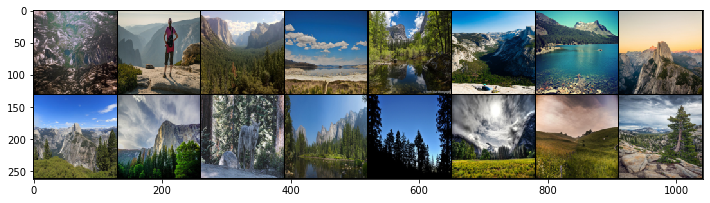

In [0]:
# helper imshow function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    

# get some images from X
dataiter = iter(dataloader_X)
# the "_" is a placeholder for no labels
images, _ = dataiter.next()

# show images
fig = plt.figure(figsize=(12, 8))
imshow(torchvision.utils.make_grid(images))

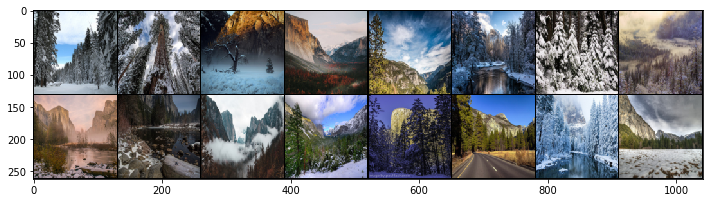

In [0]:
# get some images from Y
dataiter = iter(dataloader_Y)
images, _ = dataiter.next()

# show images
fig = plt.figure(figsize=(12,8))
imshow(torchvision.utils.make_grid(images))

In [0]:
# current range
img = images[0]

print('Min: ', img.min())
print('Max: ', img.max())

Min:  tensor(0.0314)
Max:  tensor(1.)


In [0]:
# helper scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-255.'''
    
    # scale from 0-1 to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [0]:
# scaled range
scaled_img = scale(img)

print('Scaled min: ', scaled_img.min())
print('Scaled max: ', scaled_img.max())

Scaled min:  tensor(-0.9373)
Scaled max:  tensor(1.)


In [0]:
import torch.nn as nn
import torch.nn.functional as F

# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                           kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
    
    layers.append(conv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [0]:
class Discriminator(nn.Module):
    
    def __init__(self, conv_dim=64):
        super(Discriminator, self).__init__()

        # Define all convolutional layers
        # Should accept an RGB image as input and output a single value

        # Convolutional layers, increasing in depth
        # first layer has *no* batchnorm
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False) # x, y = 64, depth 64
        self.conv2 = conv(conv_dim, conv_dim*2, 4) # (32, 32, 128)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4) # (16, 16, 256)
        self.conv4 = conv(conv_dim*4, conv_dim*8, 4) # (8, 8, 512)
        
        # Classification layer
        self.conv5 = conv(conv_dim*8, 1, 4, stride=1, batch_norm=False)

    def forward(self, x):
        # relu applied to all conv layers but last
        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        out = F.relu(self.conv3(out))
        out = F.relu(self.conv4(out))
        # last, classification layer
        out = self.conv5(out)
        return out

In [0]:
# residual block class
class ResidualBlock(nn.Module):
    """Defines a residual block.
       This adds an input x to a convolutional layer (applied to x) with the same size input and output.
       These blocks allow a model to learn an effective transformation from one domain to another.
    """
    def __init__(self, conv_dim):
        super(ResidualBlock, self).__init__()
        # conv_dim = number of inputs
        
        # define two convolutional layers + batch normalization that will act as our residual function, F(x)
        # layers should have the same shape input as output; I suggest a kernel_size of 3
        
        self.conv_layer1 = conv(in_channels=conv_dim, out_channels=conv_dim, 
                                kernel_size=3, stride=1, padding=1, batch_norm=True)
        
        self.conv_layer2 = conv(in_channels=conv_dim, out_channels=conv_dim, 
                               kernel_size=3, stride=1, padding=1, batch_norm=True)
        
    def forward(self, x):
        # apply a ReLu activation the outputs of the first layer
        # return a summed output, x + resnet_block(x)
        out_1 = F.relu(self.conv_layer1(x))
        out_2 = x + self.conv_layer2(out_1)
        return out_2
    

In [0]:
# helper deconv function
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transpose convolutional layer, with optional batch normalization.
    """
    layers = []
    # append transpose conv layer
    layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False))
    # optional batch norm layer
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [0]:
class CycleGenerator(nn.Module):
    
    def __init__(self, conv_dim=64, n_res_blocks=6):
        super(CycleGenerator, self).__init__()

        # 1. Define the encoder part of the generator
        
        # initial convolutional layer given, below
        self.conv1 = conv(3, conv_dim, 4)
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)

        # 2. Define the resnet part of the generator
        # Residual blocks
        res_layers = []
        for layer in range(n_res_blocks):
            res_layers.append(ResidualBlock(conv_dim*4))
        # use sequential to create these layers
        self.res_blocks = nn.Sequential(*res_layers)

        # 3. Define the decoder part of the generator
        # two transpose convolutional layers and a third that looks a lot like the initial conv layer
        self.deconv1 = deconv(conv_dim*4, conv_dim*2, 4)
        self.deconv2 = deconv(conv_dim*2, conv_dim, 4)
        # no batch norm on last layer
        self.deconv3 = deconv(conv_dim, 3, 4, batch_norm=False)

    def forward(self, x):
        """Given an image x, returns a transformed image."""
        # define feedforward behavior, applying activations as necessary

        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        out = F.relu(self.conv3(out))

        out = self.res_blocks(out)

        out = F.relu(self.deconv1(out))
        out = F.relu(self.deconv2(out))
        # tanh applied to last layer
        out = F.tanh(self.deconv3(out))

        return out

In [0]:
def create_model(g_conv_dim=64, d_conv_dim=64, n_res_blocks=6):
    """Builds the generators and discriminators."""
    
    # Instantiate generators
    G_XtoY = CycleGenerator(conv_dim=g_conv_dim, n_res_blocks=n_res_blocks)
    G_YtoX = CycleGenerator(conv_dim=g_conv_dim, n_res_blocks=n_res_blocks)
    # Instantiate discriminators
    D_X = Discriminator(conv_dim=d_conv_dim)
    D_Y = Discriminator(conv_dim=d_conv_dim)

    # move models to GPU, if available
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
        G_XtoY.to(device)
        G_YtoX.to(device)
        D_X.to(device)
        D_Y.to(device)
        print('Models moved to GPU.')
    else:
        print('Only CPU available.')

    return G_XtoY, G_YtoX, D_X, D_Y

In [0]:
# call the function to get models
G_XtoY, G_YtoX, D_X, D_Y = create_model()

Models moved to GPU.


In [0]:
# helper function for printing the model architecture
def print_models(G_XtoY, G_YtoX, D_X, D_Y):
    """Prints model information for the generators and discriminators.
    """
    print("                     G_XtoY                    ")
    print("-----------------------------------------------")
    print(G_XtoY)
    print()

    print("                     G_YtoX                    ")
    print("-----------------------------------------------")
    print(G_YtoX)
    print()

    print("                      D_X                      ")
    print("-----------------------------------------------")
    print(D_X)
    print()

    print("                      D_Y                      ")
    print("-----------------------------------------------")
    print(D_Y)
    print()
    

# print all of the models
print_models(G_XtoY, G_YtoX, D_X, D_Y)

                     G_XtoY                    
-----------------------------------------------
CycleGenerator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (res_blocks): Sequential(
    (0): ResidualBlock(
      (conv_layer1): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

In [0]:
def real_mse_loss(D_out):
    # how close is the produced output from being "real"?
    return torch.mean((D_out-1)**2)

def fake_mse_loss(D_out):
    # how close is the produced output from being "false"?
    return torch.mean(D_out**2)

def cycle_consistency_loss(real_im, reconstructed_im, lambda_weight):
    # calculate reconstruction loss 
    # as absolute value difference between the real and reconstructed images
    reconstr_loss = torch.mean(torch.abs(real_im - reconstructed_im))
    # return weighted loss
    return lambda_weight*reconstr_loss    


In [0]:
import torch.optim as optim

# hyperparams for Adam optimizer
lr=0.0002
beta1=0.5
beta2=0.999 # default value

g_params = list(G_XtoY.parameters()) + list(G_YtoX.parameters())  # Get generator parameters

# Create optimizers for the generators and discriminators
g_optimizer = optim.Adam(g_params, lr, [beta1, beta2])
d_x_optimizer = optim.Adam(D_X.parameters(), lr, [beta1, beta2])
d_y_optimizer = optim.Adam(D_Y.parameters(), lr, [beta1, beta2])

In [0]:
!ls /content/drive/My\ Drive/Colab\ Notebooks/CycleGAN/

checkpoints_cyclegan	 notebook_images   summer2winter_yosemite
CycleGAN_Solution.ipynb  __pycache__	   summer2winter_yosemite.zip
helpers.py		 samples_cyclegan


In [0]:
# import save code
import sys
sys.path.insert(0, '/content/drive/My Drive/Colab Notebooks/CycleGAN/')
from helpers import save_samples, checkpoint

In [0]:
# train the network
def training_loop(dataloader_X, dataloader_Y, test_dataloader_X, test_dataloader_Y, 
                  n_epochs=1000):
    
    print_every=10
    
    # keep track of losses over time
    losses = []
    
    test_iter_X = iter(test_dataloader_X)
    test_iter_Y = iter(test_dataloader_Y)

    # Get some fixed data from domains X and Y for sampling. These are images that are held
    # constant throughout training, that allow us to inspect the model's performance.
    fixed_X = test_iter_X.next()[0]
    fixed_Y = test_iter_Y.next()[0]
    fixed_X = scale(fixed_X) # make sure to scale to a range -1 to 1
    fixed_Y = scale(fixed_Y)

    # batches per epoch
    iter_X = iter(dataloader_X)
    iter_Y = iter(dataloader_Y)
    batches_per_epoch = min(len(iter_X), len(iter_Y))

    for epoch in range(1, n_epochs+1):

        # Reset iterators for each epoch
        if epoch % batches_per_epoch == 0:
            iter_X = iter(dataloader_X)
            iter_Y = iter(dataloader_Y)

        images_X, _ = iter_X.next()
        images_X = scale(images_X) # make sure to scale to a range -1 to 1

        images_Y, _ = iter_Y.next()
        images_Y = scale(images_Y)
        
        # move images to GPU if available (otherwise stay on CPU)
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        images_X = images_X.to(device)
        images_Y = images_Y.to(device)


        # ============================================
        #            TRAIN THE DISCRIMINATORS
        # ============================================

        ##   First: D_X, real and fake loss components   ##

        # Train with real images
        d_x_optimizer.zero_grad()

        # 1. Compute the discriminator losses on real images
        out_x = D_X(images_X)
        D_X_real_loss = real_mse_loss(out_x)
        
        # Train with fake images
        
        # 2. Generate fake images that look like domain X based on real images in domain Y
        fake_X = G_YtoX(images_Y)

        # 3. Compute the fake loss for D_X
        out_x = D_X(fake_X)
        D_X_fake_loss = fake_mse_loss(out_x)
        

        # 4. Compute the total loss and perform backprop
        d_x_loss = D_X_real_loss + D_X_fake_loss
        d_x_loss.backward()
        d_x_optimizer.step()

        
        ##   Second: D_Y, real and fake loss components   ##
        
        # Train with real images
        d_y_optimizer.zero_grad()
        
        # 1. Compute the discriminator losses on real images
        out_y = D_Y(images_Y)
        D_Y_real_loss = real_mse_loss(out_y)
        
        # Train with fake images

        # 2. Generate fake images that look like domain Y based on real images in domain X
        fake_Y = G_XtoY(images_X)

        # 3. Compute the fake loss for D_Y
        out_y = D_Y(fake_Y)
        D_Y_fake_loss = fake_mse_loss(out_y)

        # 4. Compute the total loss and perform backprop
        d_y_loss = D_Y_real_loss + D_Y_fake_loss
        d_y_loss.backward()
        d_y_optimizer.step()


        # =========================================
        #            TRAIN THE GENERATORS
        # =========================================

        ##    First: generate fake X images and reconstructed Y images    ##
        g_optimizer.zero_grad()

        # 1. Generate fake images that look like domain X based on real images in domain Y
        fake_X = G_YtoX(images_Y)

        # 2. Compute the generator loss based on domain X
        out_x = D_X(fake_X)
        g_YtoX_loss = real_mse_loss(out_x)

        # 3. Create a reconstructed y
        # 4. Compute the cycle consistency loss (the reconstruction loss)
        reconstructed_Y = G_XtoY(fake_X)
        reconstructed_y_loss = cycle_consistency_loss(images_Y, reconstructed_Y, lambda_weight=10)


        ##    Second: generate fake Y images and reconstructed X images    ##

        # 1. Generate fake images that look like domain Y based on real images in domain X
        fake_Y = G_XtoY(images_X)

        # 2. Compute the generator loss based on domain Y
        out_y = D_Y(fake_Y)
        g_XtoY_loss = real_mse_loss(out_y)

        # 3. Create a reconstructed x
        # 4. Compute the cycle consistency loss (the reconstruction loss)
        reconstructed_X = G_YtoX(fake_Y)
        reconstructed_x_loss = cycle_consistency_loss(images_X, reconstructed_X, lambda_weight=10)

        # 5. Add up all generator and reconstructed losses and perform backprop
        g_total_loss = g_YtoX_loss + g_XtoY_loss + reconstructed_y_loss + reconstructed_x_loss
        g_total_loss.backward()
        g_optimizer.step()


        # Print the log info
        if epoch % print_every == 0:
            # append real and fake discriminator losses and the generator loss
            losses.append((d_x_loss.item(), d_y_loss.item(), g_total_loss.item()))
            print('Epoch [{:5d}/{:5d}] | d_X_loss: {:6.4f} | d_Y_loss: {:6.4f} | g_total_loss: {:6.4f}'.format(
                    epoch, n_epochs, d_x_loss.item(), d_y_loss.item(), g_total_loss.item()))

            
        sample_every=100
        # Save the generated samples
        if epoch % sample_every == 0:
            G_YtoX.eval() # set generators to eval mode for sample generation
            G_XtoY.eval()
            save_samples(epoch, fixed_Y, fixed_X, G_YtoX, G_XtoY, batch_size=16)
            G_YtoX.train()
            G_XtoY.train()

        # uncomment these lines, if you want to save your model
#         checkpoint_every=1000
#         # Save the model parameters
#         if epoch % checkpoint_every == 0:
#             checkpoint(epoch, G_XtoY, G_YtoX, D_X, D_Y)

    return losses


In [0]:
n_epochs = 5000 # keep this small when testing if a model first works

losses = training_loop(dataloader_X, dataloader_Y, test_dataloader_X, test_dataloader_Y, n_epochs=n_epochs)

Epoch [   10/ 5000] | d_X_loss: 0.3268 | d_Y_loss: 0.3894 | g_total_loss: 10.9894
Epoch [   20/ 5000] | d_X_loss: 0.4009 | d_Y_loss: 0.2342 | g_total_loss: 8.1462
Epoch [   30/ 5000] | d_X_loss: 0.4383 | d_Y_loss: 0.3431 | g_total_loss: 8.1528
Epoch [   40/ 5000] | d_X_loss: 0.7277 | d_Y_loss: 0.4567 | g_total_loss: 8.0038
Epoch [   50/ 5000] | d_X_loss: 0.1259 | d_Y_loss: 0.3565 | g_total_loss: 7.1299
Epoch [   60/ 5000] | d_X_loss: 0.5456 | d_Y_loss: 0.6007 | g_total_loss: 6.5385
Epoch [   70/ 5000] | d_X_loss: 0.6929 | d_Y_loss: 0.2801 | g_total_loss: 5.7839
Epoch [   80/ 5000] | d_X_loss: 0.2986 | d_Y_loss: 0.3430 | g_total_loss: 6.2000
Epoch [   90/ 5000] | d_X_loss: 0.4169 | d_Y_loss: 0.4155 | g_total_loss: 6.0346
Epoch [  100/ 5000] | d_X_loss: 0.2807 | d_Y_loss: 0.3521 | g_total_loss: 5.5773


Saved /content/drive/My Drive/Colab Notebooks/CycleGAN/samples_cyclegan/sample-000100-X-Y.png


Saved /content/drive/My Drive/Colab Notebooks/CycleGAN/samples_cyclegan/sample-000100-Y-X.png
Epoch [  110/ 5000] | d_X_loss: 0.3204 | d_Y_loss: 0.4733 | g_total_loss: 5.8010
Epoch [  120/ 5000] | d_X_loss: 0.5474 | d_Y_loss: 0.3648 | g_total_loss: 5.7070
Epoch [  130/ 5000] | d_X_loss: 0.4353 | d_Y_loss: 0.3377 | g_total_loss: 6.5558
Epoch [  140/ 5000] | d_X_loss: 0.3096 | d_Y_loss: 0.3388 | g_total_loss: 5.3802
Epoch [  150/ 5000] | d_X_loss: 0.3785 | d_Y_loss: 0.2954 | g_total_loss: 5.2067
Epoch [  160/ 5000] | d_X_loss: 0.3663 | d_Y_loss: 0.3078 | g_total_loss: 5.2259
Epoch [  170/ 5000] | d_X_loss: 0.2914 | d_Y_loss: 0.4063 | g_total_loss: 5.0002
Epoch [  180/ 5000] | d_X_loss: 0.4147 | d_Y_loss: 0.3410 | g_total_loss: 5.9041
Epoch [  190/ 5000] | d_X_loss: 0.3697 | d_Y_loss: 0.3138 | g_total_loss: 5.2159
Epoch [  200/ 5000] | d_X_loss: 0.3802 | d_Y_loss: 0.4695 | g_total_loss: 5.2205


Saved /content/drive/My Drive/Colab Notebooks/CycleGAN/samples_cyclegan/sample-000200-X-Y.png


Saved /content/drive/My Drive/Colab Notebooks/CycleGAN/samples_cyclegan/sample-000200-Y-X.png
Epoch [  210/ 5000] | d_X_loss: 0.5449 | d_Y_loss: 0.3179 | g_total_loss: 4.8927
Epoch [  220/ 5000] | d_X_loss: 0.2983 | d_Y_loss: 0.3205 | g_total_loss: 5.6822
Epoch [  230/ 5000] | d_X_loss: 0.3053 | d_Y_loss: 0.4578 | g_total_loss: 5.4862
Epoch [  240/ 5000] | d_X_loss: 0.2908 | d_Y_loss: 0.4401 | g_total_loss: 4.5086
Epoch [  250/ 5000] | d_X_loss: 0.4003 | d_Y_loss: 0.2994 | g_total_loss: 5.3309
Epoch [  260/ 5000] | d_X_loss: 0.5759 | d_Y_loss: 0.4408 | g_total_loss: 4.1482
Epoch [  270/ 5000] | d_X_loss: 0.3492 | d_Y_loss: 0.3552 | g_total_loss: 5.0896
Epoch [  280/ 5000] | d_X_loss: 0.2894 | d_Y_loss: 0.2899 | g_total_loss: 6.2115
Epoch [  290/ 5000] | d_X_loss: 0.5226 | d_Y_loss: 0.3517 | g_total_loss: 5.4071
Epoch [  300/ 5000] | d_X_loss: 0.3379 | d_Y_loss: 0.3117 | g_total_loss: 5.3121


Saved /content/drive/My Drive/Colab Notebooks/CycleGAN/samples_cyclegan/sample-000300-X-Y.png


Saved /content/drive/My Drive/Colab Notebooks/CycleGAN/samples_cyclegan/sample-000300-Y-X.png
Epoch [  310/ 5000] | d_X_loss: 0.2699 | d_Y_loss: 0.2549 | g_total_loss: 4.7209
Epoch [  320/ 5000] | d_X_loss: 0.2285 | d_Y_loss: 0.1794 | g_total_loss: 5.3631
Epoch [  330/ 5000] | d_X_loss: 0.3756 | d_Y_loss: 0.4113 | g_total_loss: 3.9745
Epoch [  340/ 5000] | d_X_loss: 0.3709 | d_Y_loss: 0.2441 | g_total_loss: 4.7497
Epoch [  350/ 5000] | d_X_loss: 0.3754 | d_Y_loss: 0.5840 | g_total_loss: 5.2535
Epoch [  360/ 5000] | d_X_loss: 0.2830 | d_Y_loss: 0.2348 | g_total_loss: 5.2848
Epoch [  370/ 5000] | d_X_loss: 0.3854 | d_Y_loss: 0.3275 | g_total_loss: 4.9199
Epoch [  380/ 5000] | d_X_loss: 0.2835 | d_Y_loss: 0.3592 | g_total_loss: 4.7624
Epoch [  390/ 5000] | d_X_loss: 0.3657 | d_Y_loss: 0.4129 | g_total_loss: 5.6855
Epoch [  400/ 5000] | d_X_loss: 0.3532 | d_Y_loss: 0.2007 | g_total_loss: 5.1115


Saved /content/drive/My Drive/Colab Notebooks/CycleGAN/samples_cyclegan/sample-000400-X-Y.png


Saved /content/drive/My Drive/Colab Notebooks/CycleGAN/samples_cyclegan/sample-000400-Y-X.png
Epoch [  410/ 5000] | d_X_loss: 0.3123 | d_Y_loss: 0.4132 | g_total_loss: 4.0589
Epoch [  420/ 5000] | d_X_loss: 0.2800 | d_Y_loss: 0.3183 | g_total_loss: 5.0840
Epoch [  430/ 5000] | d_X_loss: 0.2522 | d_Y_loss: 0.5980 | g_total_loss: 6.2181
Epoch [  440/ 5000] | d_X_loss: 0.3926 | d_Y_loss: 0.3961 | g_total_loss: 4.8121
Epoch [  450/ 5000] | d_X_loss: 0.4409 | d_Y_loss: 0.4285 | g_total_loss: 4.2829
Epoch [  460/ 5000] | d_X_loss: 0.2783 | d_Y_loss: 0.3288 | g_total_loss: 4.5204
Epoch [  470/ 5000] | d_X_loss: 0.2760 | d_Y_loss: 0.2009 | g_total_loss: 5.4412
Epoch [  480/ 5000] | d_X_loss: 0.3274 | d_Y_loss: 0.3657 | g_total_loss: 4.2849
Epoch [  490/ 5000] | d_X_loss: 0.2445 | d_Y_loss: 0.2460 | g_total_loss: 5.8146
Epoch [  500/ 5000] | d_X_loss: 0.4041 | d_Y_loss: 0.2938 | g_total_loss: 4.5269


Saved /content/drive/My Drive/Colab Notebooks/CycleGAN/samples_cyclegan/sample-000500-X-Y.png


Saved /content/drive/My Drive/Colab Notebooks/CycleGAN/samples_cyclegan/sample-000500-Y-X.png
Epoch [  510/ 5000] | d_X_loss: 0.4148 | d_Y_loss: 0.3474 | g_total_loss: 3.9360
Epoch [  520/ 5000] | d_X_loss: 0.6078 | d_Y_loss: 0.3226 | g_total_loss: 5.6294
Epoch [  530/ 5000] | d_X_loss: 0.3544 | d_Y_loss: 0.3650 | g_total_loss: 4.4724
Epoch [  540/ 5000] | d_X_loss: 0.4340 | d_Y_loss: 0.3533 | g_total_loss: 4.3607
Epoch [  550/ 5000] | d_X_loss: 0.2669 | d_Y_loss: 0.2502 | g_total_loss: 5.4100
Epoch [  560/ 5000] | d_X_loss: 0.4262 | d_Y_loss: 0.3203 | g_total_loss: 4.6109
Epoch [  570/ 5000] | d_X_loss: 0.5167 | d_Y_loss: 0.2762 | g_total_loss: 5.2632
Epoch [  580/ 5000] | d_X_loss: 0.2452 | d_Y_loss: 0.2499 | g_total_loss: 4.5696
Epoch [  590/ 5000] | d_X_loss: 0.4059 | d_Y_loss: 0.2978 | g_total_loss: 5.7967
Epoch [  600/ 5000] | d_X_loss: 0.2844 | d_Y_loss: 0.1848 | g_total_loss: 4.7640


Saved /content/drive/My Drive/Colab Notebooks/CycleGAN/samples_cyclegan/sample-000600-X-Y.png


Saved /content/drive/My Drive/Colab Notebooks/CycleGAN/samples_cyclegan/sample-000600-Y-X.png
Epoch [  610/ 5000] | d_X_loss: 0.2667 | d_Y_loss: 0.4049 | g_total_loss: 5.4177
Epoch [  620/ 5000] | d_X_loss: 0.3950 | d_Y_loss: 0.2021 | g_total_loss: 5.0016
Epoch [  630/ 5000] | d_X_loss: 0.2345 | d_Y_loss: 0.2358 | g_total_loss: 4.7557
Epoch [  640/ 5000] | d_X_loss: 0.2050 | d_Y_loss: 0.3021 | g_total_loss: 4.7250
Epoch [  650/ 5000] | d_X_loss: 0.4043 | d_Y_loss: 0.1714 | g_total_loss: 4.6295
Epoch [  660/ 5000] | d_X_loss: 0.1879 | d_Y_loss: 0.4896 | g_total_loss: 3.9416
Epoch [  670/ 5000] | d_X_loss: 0.2837 | d_Y_loss: 0.3681 | g_total_loss: 4.8141
Epoch [  680/ 5000] | d_X_loss: 0.3237 | d_Y_loss: 0.3071 | g_total_loss: 4.6091
Epoch [  690/ 5000] | d_X_loss: 0.3164 | d_Y_loss: 0.2669 | g_total_loss: 4.9498
Epoch [  700/ 5000] | d_X_loss: 0.2331 | d_Y_loss: 0.1682 | g_total_loss: 4.7822


Saved /content/drive/My Drive/Colab Notebooks/CycleGAN/samples_cyclegan/sample-000700-X-Y.png


Saved /content/drive/My Drive/Colab Notebooks/CycleGAN/samples_cyclegan/sample-000700-Y-X.png
Epoch [  710/ 5000] | d_X_loss: 0.4871 | d_Y_loss: 0.3185 | g_total_loss: 4.6673
Epoch [  720/ 5000] | d_X_loss: 0.2666 | d_Y_loss: 0.3938 | g_total_loss: 4.7282
Epoch [  730/ 5000] | d_X_loss: 0.2443 | d_Y_loss: 0.3175 | g_total_loss: 5.2971
Epoch [  740/ 5000] | d_X_loss: 0.1916 | d_Y_loss: 0.3292 | g_total_loss: 4.1265
Epoch [  750/ 5000] | d_X_loss: 0.2813 | d_Y_loss: 0.2291 | g_total_loss: 4.5457
Epoch [  760/ 5000] | d_X_loss: 0.3338 | d_Y_loss: 0.3337 | g_total_loss: 5.0197
Epoch [  770/ 5000] | d_X_loss: 0.5361 | d_Y_loss: 0.3206 | g_total_loss: 4.3189
Epoch [  780/ 5000] | d_X_loss: 0.3570 | d_Y_loss: 0.3845 | g_total_loss: 4.2978
Epoch [  790/ 5000] | d_X_loss: 0.4368 | d_Y_loss: 0.4078 | g_total_loss: 5.0953
Epoch [  800/ 5000] | d_X_loss: 0.1775 | d_Y_loss: 0.2356 | g_total_loss: 4.3577


Saved /content/drive/My Drive/Colab Notebooks/CycleGAN/samples_cyclegan/sample-000800-X-Y.png


Saved /content/drive/My Drive/Colab Notebooks/CycleGAN/samples_cyclegan/sample-000800-Y-X.png
Epoch [  810/ 5000] | d_X_loss: 0.2032 | d_Y_loss: 0.2127 | g_total_loss: 4.7303
Epoch [  820/ 5000] | d_X_loss: 0.2765 | d_Y_loss: 0.1401 | g_total_loss: 4.6660
Epoch [  830/ 5000] | d_X_loss: 0.3213 | d_Y_loss: 0.3501 | g_total_loss: 3.9188
Epoch [  840/ 5000] | d_X_loss: 0.2221 | d_Y_loss: 0.2282 | g_total_loss: 5.2374
Epoch [  850/ 5000] | d_X_loss: 0.2815 | d_Y_loss: 0.2161 | g_total_loss: 4.6949
Epoch [  860/ 5000] | d_X_loss: 0.2709 | d_Y_loss: 0.3558 | g_total_loss: 3.6583
Epoch [  870/ 5000] | d_X_loss: 0.3046 | d_Y_loss: 0.2905 | g_total_loss: 5.1378
Epoch [  880/ 5000] | d_X_loss: 0.1663 | d_Y_loss: 0.4237 | g_total_loss: 4.7225
Epoch [  890/ 5000] | d_X_loss: 0.5736 | d_Y_loss: 0.2310 | g_total_loss: 5.9397
Epoch [  900/ 5000] | d_X_loss: 0.2825 | d_Y_loss: 0.3269 | g_total_loss: 3.5523


Saved /content/drive/My Drive/Colab Notebooks/CycleGAN/samples_cyclegan/sample-000900-X-Y.png


Saved /content/drive/My Drive/Colab Notebooks/CycleGAN/samples_cyclegan/sample-000900-Y-X.png
Epoch [  910/ 5000] | d_X_loss: 0.2791 | d_Y_loss: 0.1973 | g_total_loss: 4.2870
Epoch [  920/ 5000] | d_X_loss: 0.2940 | d_Y_loss: 0.2624 | g_total_loss: 4.3463
Epoch [  930/ 5000] | d_X_loss: 0.2790 | d_Y_loss: 0.2124 | g_total_loss: 3.9117
Epoch [  940/ 5000] | d_X_loss: 0.4242 | d_Y_loss: 0.2188 | g_total_loss: 5.7314
Epoch [  950/ 5000] | d_X_loss: 0.2900 | d_Y_loss: 0.3283 | g_total_loss: 3.7731
Epoch [  960/ 5000] | d_X_loss: 0.1635 | d_Y_loss: 0.3279 | g_total_loss: 4.6872
Epoch [  970/ 5000] | d_X_loss: 0.2524 | d_Y_loss: 0.3010 | g_total_loss: 4.8233
Epoch [  980/ 5000] | d_X_loss: 0.2320 | d_Y_loss: 0.1806 | g_total_loss: 4.9917
Epoch [  990/ 5000] | d_X_loss: 0.0889 | d_Y_loss: 0.2568 | g_total_loss: 5.3960
Epoch [ 1000/ 5000] | d_X_loss: 0.3218 | d_Y_loss: 0.1473 | g_total_loss: 4.9338


Saved /content/drive/My Drive/Colab Notebooks/CycleGAN/samples_cyclegan/sample-001000-X-Y.png


Saved /content/drive/My Drive/Colab Notebooks/CycleGAN/samples_cyclegan/sample-001000-Y-X.png
Epoch [ 1010/ 5000] | d_X_loss: 0.1810 | d_Y_loss: 0.1609 | g_total_loss: 5.2245
Epoch [ 1020/ 5000] | d_X_loss: 0.2214 | d_Y_loss: 0.1584 | g_total_loss: 4.6952
Epoch [ 1030/ 5000] | d_X_loss: 0.2365 | d_Y_loss: 0.4006 | g_total_loss: 3.5621
Epoch [ 1040/ 5000] | d_X_loss: 0.3153 | d_Y_loss: 0.2479 | g_total_loss: 6.2334
Epoch [ 1050/ 5000] | d_X_loss: 0.3188 | d_Y_loss: 0.3442 | g_total_loss: 4.7623
Epoch [ 1060/ 5000] | d_X_loss: 0.1907 | d_Y_loss: 0.8047 | g_total_loss: 4.4145
Epoch [ 1070/ 5000] | d_X_loss: 1.4578 | d_Y_loss: 0.1931 | g_total_loss: 3.6540
Epoch [ 1080/ 5000] | d_X_loss: 0.2139 | d_Y_loss: 0.3434 | g_total_loss: 4.5339
Epoch [ 1090/ 5000] | d_X_loss: 0.2941 | d_Y_loss: 0.2573 | g_total_loss: 4.6469
Epoch [ 1100/ 5000] | d_X_loss: 0.2339 | d_Y_loss: 0.4049 | g_total_loss: 4.8787


Saved /content/drive/My Drive/Colab Notebooks/CycleGAN/samples_cyclegan/sample-001100-X-Y.png


Saved /content/drive/My Drive/Colab Notebooks/CycleGAN/samples_cyclegan/sample-001100-Y-X.png
Epoch [ 1110/ 5000] | d_X_loss: 0.3139 | d_Y_loss: 0.3648 | g_total_loss: 6.2139
Epoch [ 1120/ 5000] | d_X_loss: 0.2762 | d_Y_loss: 0.2181 | g_total_loss: 4.2960
Epoch [ 1130/ 5000] | d_X_loss: 0.2829 | d_Y_loss: 0.1315 | g_total_loss: 3.9662
Epoch [ 1140/ 5000] | d_X_loss: 0.2705 | d_Y_loss: 0.5236 | g_total_loss: 6.4581
Epoch [ 1150/ 5000] | d_X_loss: 0.3726 | d_Y_loss: 0.1434 | g_total_loss: 4.4870
Epoch [ 1160/ 5000] | d_X_loss: 0.1081 | d_Y_loss: 0.3325 | g_total_loss: 6.3463
Epoch [ 1170/ 5000] | d_X_loss: 0.1258 | d_Y_loss: 0.2547 | g_total_loss: 5.5731
Epoch [ 1180/ 5000] | d_X_loss: 0.2007 | d_Y_loss: 0.2685 | g_total_loss: 4.1785
Epoch [ 1190/ 5000] | d_X_loss: 0.1753 | d_Y_loss: 0.3044 | g_total_loss: 4.5942
Epoch [ 1200/ 5000] | d_X_loss: 0.3271 | d_Y_loss: 0.3350 | g_total_loss: 7.1204


Saved /content/drive/My Drive/Colab Notebooks/CycleGAN/samples_cyclegan/sample-001200-X-Y.png


Saved /content/drive/My Drive/Colab Notebooks/CycleGAN/samples_cyclegan/sample-001200-Y-X.png
Epoch [ 1210/ 5000] | d_X_loss: 0.4203 | d_Y_loss: 0.1153 | g_total_loss: 3.6426
Epoch [ 1220/ 5000] | d_X_loss: 0.2087 | d_Y_loss: 0.1613 | g_total_loss: 5.1045
Epoch [ 1230/ 5000] | d_X_loss: 0.3784 | d_Y_loss: 0.4122 | g_total_loss: 5.5321
Epoch [ 1240/ 5000] | d_X_loss: 0.2086 | d_Y_loss: 0.3531 | g_total_loss: 4.5818
Epoch [ 1250/ 5000] | d_X_loss: 0.2411 | d_Y_loss: 0.2246 | g_total_loss: 4.9686
Epoch [ 1260/ 5000] | d_X_loss: 0.1483 | d_Y_loss: 0.1782 | g_total_loss: 4.9867
Epoch [ 1270/ 5000] | d_X_loss: 0.1938 | d_Y_loss: 0.3097 | g_total_loss: 4.9979
Epoch [ 1280/ 5000] | d_X_loss: 0.2398 | d_Y_loss: 0.3888 | g_total_loss: 6.9810
Epoch [ 1290/ 5000] | d_X_loss: 0.2151 | d_Y_loss: 0.2878 | g_total_loss: 4.9435
Epoch [ 1300/ 5000] | d_X_loss: 0.0960 | d_Y_loss: 0.1590 | g_total_loss: 4.9961


Saved /content/drive/My Drive/Colab Notebooks/CycleGAN/samples_cyclegan/sample-001300-X-Y.png


Saved /content/drive/My Drive/Colab Notebooks/CycleGAN/samples_cyclegan/sample-001300-Y-X.png
Epoch [ 1310/ 5000] | d_X_loss: 0.3358 | d_Y_loss: 0.2823 | g_total_loss: 4.4945
Epoch [ 1320/ 5000] | d_X_loss: 0.1817 | d_Y_loss: 0.0881 | g_total_loss: 4.9315
Epoch [ 1330/ 5000] | d_X_loss: 0.1417 | d_Y_loss: 0.1614 | g_total_loss: 5.0558
Epoch [ 1340/ 5000] | d_X_loss: 0.3073 | d_Y_loss: 0.1518 | g_total_loss: 4.2855
Epoch [ 1350/ 5000] | d_X_loss: 0.1370 | d_Y_loss: 0.4216 | g_total_loss: 3.9892
Epoch [ 1360/ 5000] | d_X_loss: 0.2916 | d_Y_loss: 0.4164 | g_total_loss: 5.0590
Epoch [ 1370/ 5000] | d_X_loss: 0.1498 | d_Y_loss: 0.7311 | g_total_loss: 4.2755
Epoch [ 1380/ 5000] | d_X_loss: 0.1449 | d_Y_loss: 0.1589 | g_total_loss: 4.7906
Epoch [ 1390/ 5000] | d_X_loss: 0.2364 | d_Y_loss: 0.3722 | g_total_loss: 4.2317
Epoch [ 1400/ 5000] | d_X_loss: 0.1742 | d_Y_loss: 0.1295 | g_total_loss: 4.2872


Saved /content/drive/My Drive/Colab Notebooks/CycleGAN/samples_cyclegan/sample-001400-X-Y.png


Saved /content/drive/My Drive/Colab Notebooks/CycleGAN/samples_cyclegan/sample-001400-Y-X.png
Epoch [ 1410/ 5000] | d_X_loss: 0.2706 | d_Y_loss: 0.2510 | g_total_loss: 4.0516
Epoch [ 1420/ 5000] | d_X_loss: 0.3164 | d_Y_loss: 0.2663 | g_total_loss: 4.2707
Epoch [ 1430/ 5000] | d_X_loss: 0.0950 | d_Y_loss: 0.3492 | g_total_loss: 5.2221
Epoch [ 1440/ 5000] | d_X_loss: 0.2838 | d_Y_loss: 0.3098 | g_total_loss: 4.7327
Epoch [ 1450/ 5000] | d_X_loss: 0.4305 | d_Y_loss: 0.3388 | g_total_loss: 4.7156
Epoch [ 1460/ 5000] | d_X_loss: 0.1988 | d_Y_loss: 0.3478 | g_total_loss: 5.1136
Epoch [ 1470/ 5000] | d_X_loss: 0.1232 | d_Y_loss: 0.1844 | g_total_loss: 4.3789
Epoch [ 1480/ 5000] | d_X_loss: 0.2210 | d_Y_loss: 0.5699 | g_total_loss: 5.2368
Epoch [ 1490/ 5000] | d_X_loss: 0.1844 | d_Y_loss: 0.1998 | g_total_loss: 4.9517
Epoch [ 1500/ 5000] | d_X_loss: 0.1104 | d_Y_loss: 0.5039 | g_total_loss: 4.4921


Saved /content/drive/My Drive/Colab Notebooks/CycleGAN/samples_cyclegan/sample-001500-X-Y.png


Saved /content/drive/My Drive/Colab Notebooks/CycleGAN/samples_cyclegan/sample-001500-Y-X.png
Epoch [ 1510/ 5000] | d_X_loss: 0.1667 | d_Y_loss: 0.2900 | g_total_loss: 5.2211
Epoch [ 1520/ 5000] | d_X_loss: 0.1370 | d_Y_loss: 0.1616 | g_total_loss: 4.0586
Epoch [ 1530/ 5000] | d_X_loss: 0.1762 | d_Y_loss: 0.2022 | g_total_loss: 4.1489
Epoch [ 1540/ 5000] | d_X_loss: 0.3137 | d_Y_loss: 0.3339 | g_total_loss: 5.5267
Epoch [ 1550/ 5000] | d_X_loss: 0.2146 | d_Y_loss: 0.0919 | g_total_loss: 4.5331
Epoch [ 1560/ 5000] | d_X_loss: 0.2615 | d_Y_loss: 0.1915 | g_total_loss: 4.1142
Epoch [ 1570/ 5000] | d_X_loss: 0.1782 | d_Y_loss: 0.3483 | g_total_loss: 6.1133
Epoch [ 1580/ 5000] | d_X_loss: 0.2201 | d_Y_loss: 0.3931 | g_total_loss: 5.7698
Epoch [ 1590/ 5000] | d_X_loss: 0.2093 | d_Y_loss: 0.4418 | g_total_loss: 3.8875
Epoch [ 1600/ 5000] | d_X_loss: 0.1294 | d_Y_loss: 0.2612 | g_total_loss: 5.1061


Saved /content/drive/My Drive/Colab Notebooks/CycleGAN/samples_cyclegan/sample-001600-X-Y.png


Saved /content/drive/My Drive/Colab Notebooks/CycleGAN/samples_cyclegan/sample-001600-Y-X.png
Epoch [ 1610/ 5000] | d_X_loss: 0.1879 | d_Y_loss: 0.1997 | g_total_loss: 4.7173
Epoch [ 1620/ 5000] | d_X_loss: 0.1185 | d_Y_loss: 0.1463 | g_total_loss: 5.0693
Epoch [ 1630/ 5000] | d_X_loss: 0.2870 | d_Y_loss: 0.2487 | g_total_loss: 5.1326
Epoch [ 1640/ 5000] | d_X_loss: 0.2812 | d_Y_loss: 0.0863 | g_total_loss: 3.9997
Epoch [ 1650/ 5000] | d_X_loss: 0.2106 | d_Y_loss: 0.1740 | g_total_loss: 5.7783
Epoch [ 1660/ 5000] | d_X_loss: 0.1211 | d_Y_loss: 0.1863 | g_total_loss: 5.5587
Epoch [ 1670/ 5000] | d_X_loss: 0.1392 | d_Y_loss: 0.3639 | g_total_loss: 5.1079
Epoch [ 1680/ 5000] | d_X_loss: 0.1618 | d_Y_loss: 0.4889 | g_total_loss: 5.3021
Epoch [ 1690/ 5000] | d_X_loss: 0.0596 | d_Y_loss: 0.1392 | g_total_loss: 4.0239
Epoch [ 1700/ 5000] | d_X_loss: 0.2252 | d_Y_loss: 0.1457 | g_total_loss: 4.3456


Saved /content/drive/My Drive/Colab Notebooks/CycleGAN/samples_cyclegan/sample-001700-X-Y.png


Saved /content/drive/My Drive/Colab Notebooks/CycleGAN/samples_cyclegan/sample-001700-Y-X.png
Epoch [ 1710/ 5000] | d_X_loss: 0.1612 | d_Y_loss: 0.0984 | g_total_loss: 5.6519
Epoch [ 1720/ 5000] | d_X_loss: 0.3224 | d_Y_loss: 0.2265 | g_total_loss: 4.6847
Epoch [ 1730/ 5000] | d_X_loss: 0.0864 | d_Y_loss: 0.4136 | g_total_loss: 3.4158
Epoch [ 1740/ 5000] | d_X_loss: 0.1390 | d_Y_loss: 0.2606 | g_total_loss: 4.8511
Epoch [ 1750/ 5000] | d_X_loss: 0.2657 | d_Y_loss: 0.1651 | g_total_loss: 4.1130
Epoch [ 1760/ 5000] | d_X_loss: 0.0355 | d_Y_loss: 0.1568 | g_total_loss: 5.8447
Epoch [ 1770/ 5000] | d_X_loss: 0.1596 | d_Y_loss: 0.4262 | g_total_loss: 5.3868
Epoch [ 1780/ 5000] | d_X_loss: 0.3020 | d_Y_loss: 0.1432 | g_total_loss: 4.5366
Epoch [ 1790/ 5000] | d_X_loss: 0.1463 | d_Y_loss: 0.2245 | g_total_loss: 4.1268
Epoch [ 1800/ 5000] | d_X_loss: 0.1176 | d_Y_loss: 0.1986 | g_total_loss: 4.5130


Saved /content/drive/My Drive/Colab Notebooks/CycleGAN/samples_cyclegan/sample-001800-X-Y.png


Saved /content/drive/My Drive/Colab Notebooks/CycleGAN/samples_cyclegan/sample-001800-Y-X.png
Epoch [ 1810/ 5000] | d_X_loss: 0.0485 | d_Y_loss: 0.1409 | g_total_loss: 5.0363
Epoch [ 1820/ 5000] | d_X_loss: 0.1123 | d_Y_loss: 0.1100 | g_total_loss: 4.6030
Epoch [ 1830/ 5000] | d_X_loss: 0.0724 | d_Y_loss: 0.2541 | g_total_loss: 4.5851
Epoch [ 1840/ 5000] | d_X_loss: 0.3030 | d_Y_loss: 0.2991 | g_total_loss: 4.8128
Epoch [ 1850/ 5000] | d_X_loss: 0.1513 | d_Y_loss: 0.1131 | g_total_loss: 4.3854
Epoch [ 1860/ 5000] | d_X_loss: 0.2830 | d_Y_loss: 0.1083 | g_total_loss: 3.9465
Epoch [ 1870/ 5000] | d_X_loss: 0.2044 | d_Y_loss: 0.1507 | g_total_loss: 5.1212
Epoch [ 1880/ 5000] | d_X_loss: 0.0860 | d_Y_loss: 0.1355 | g_total_loss: 4.7459
Epoch [ 1890/ 5000] | d_X_loss: 0.1316 | d_Y_loss: 0.2800 | g_total_loss: 6.1592
Epoch [ 1900/ 5000] | d_X_loss: 0.1193 | d_Y_loss: 0.0987 | g_total_loss: 4.3435


Saved /content/drive/My Drive/Colab Notebooks/CycleGAN/samples_cyclegan/sample-001900-X-Y.png


Saved /content/drive/My Drive/Colab Notebooks/CycleGAN/samples_cyclegan/sample-001900-Y-X.png
Epoch [ 1910/ 5000] | d_X_loss: 0.1567 | d_Y_loss: 0.1352 | g_total_loss: 4.7813
Epoch [ 1920/ 5000] | d_X_loss: 0.1747 | d_Y_loss: 0.2089 | g_total_loss: 3.8164
Epoch [ 1930/ 5000] | d_X_loss: 0.1139 | d_Y_loss: 0.1210 | g_total_loss: 4.6124
Epoch [ 1940/ 5000] | d_X_loss: 0.1542 | d_Y_loss: 0.1847 | g_total_loss: 4.2683
Epoch [ 1950/ 5000] | d_X_loss: 0.3509 | d_Y_loss: 0.3221 | g_total_loss: 6.0641
Epoch [ 1960/ 5000] | d_X_loss: 0.2738 | d_Y_loss: 0.1925 | g_total_loss: 5.0970
Epoch [ 1970/ 5000] | d_X_loss: 0.1224 | d_Y_loss: 0.1124 | g_total_loss: 3.9464
Epoch [ 1980/ 5000] | d_X_loss: 0.1473 | d_Y_loss: 0.1110 | g_total_loss: 4.4274
Epoch [ 1990/ 5000] | d_X_loss: 0.2278 | d_Y_loss: 0.1409 | g_total_loss: 5.3012
Epoch [ 2000/ 5000] | d_X_loss: 0.2991 | d_Y_loss: 0.2099 | g_total_loss: 3.7247


Saved /content/drive/My Drive/Colab Notebooks/CycleGAN/samples_cyclegan/sample-002000-X-Y.png


Saved /content/drive/My Drive/Colab Notebooks/CycleGAN/samples_cyclegan/sample-002000-Y-X.png
Epoch [ 2010/ 5000] | d_X_loss: 0.0639 | d_Y_loss: 0.1156 | g_total_loss: 4.7527
Epoch [ 2020/ 5000] | d_X_loss: 0.1790 | d_Y_loss: 0.1746 | g_total_loss: 4.3086
Epoch [ 2030/ 5000] | d_X_loss: 0.0682 | d_Y_loss: 0.4647 | g_total_loss: 4.1144
Epoch [ 2040/ 5000] | d_X_loss: 0.1541 | d_Y_loss: 0.1388 | g_total_loss: 4.2822
Epoch [ 2050/ 5000] | d_X_loss: 0.2563 | d_Y_loss: 0.1801 | g_total_loss: 5.2042
Epoch [ 2060/ 5000] | d_X_loss: 0.2333 | d_Y_loss: 0.1421 | g_total_loss: 4.4156
Epoch [ 2070/ 5000] | d_X_loss: 0.0433 | d_Y_loss: 0.1671 | g_total_loss: 4.9059
Epoch [ 2080/ 5000] | d_X_loss: 0.1205 | d_Y_loss: 0.1160 | g_total_loss: 4.3122
Epoch [ 2090/ 5000] | d_X_loss: 0.0895 | d_Y_loss: 0.1896 | g_total_loss: 4.8291
Epoch [ 2100/ 5000] | d_X_loss: 0.1832 | d_Y_loss: 0.1584 | g_total_loss: 5.9407


Saved /content/drive/My Drive/Colab Notebooks/CycleGAN/samples_cyclegan/sample-002100-X-Y.png


Saved /content/drive/My Drive/Colab Notebooks/CycleGAN/samples_cyclegan/sample-002100-Y-X.png
Epoch [ 2110/ 5000] | d_X_loss: 0.1174 | d_Y_loss: 0.0540 | g_total_loss: 4.5972
Epoch [ 2120/ 5000] | d_X_loss: 0.1435 | d_Y_loss: 0.1201 | g_total_loss: 4.9733
Epoch [ 2130/ 5000] | d_X_loss: 0.2312 | d_Y_loss: 0.1616 | g_total_loss: 4.9091
Epoch [ 2140/ 5000] | d_X_loss: 0.2442 | d_Y_loss: 0.0813 | g_total_loss: 4.3886
Epoch [ 2150/ 5000] | d_X_loss: 0.1629 | d_Y_loss: 0.2265 | g_total_loss: 4.3495
Epoch [ 2160/ 5000] | d_X_loss: 0.1512 | d_Y_loss: 0.0986 | g_total_loss: 3.8000
Epoch [ 2170/ 5000] | d_X_loss: 0.0572 | d_Y_loss: 0.2705 | g_total_loss: 5.4533
Epoch [ 2180/ 5000] | d_X_loss: 0.0924 | d_Y_loss: 0.0837 | g_total_loss: 4.4738
Epoch [ 2190/ 5000] | d_X_loss: 0.1142 | d_Y_loss: 0.3460 | g_total_loss: 4.1827
Epoch [ 2200/ 5000] | d_X_loss: 0.0832 | d_Y_loss: 0.0894 | g_total_loss: 4.3359


Saved /content/drive/My Drive/Colab Notebooks/CycleGAN/samples_cyclegan/sample-002200-X-Y.png


Saved /content/drive/My Drive/Colab Notebooks/CycleGAN/samples_cyclegan/sample-002200-Y-X.png
Epoch [ 2210/ 5000] | d_X_loss: 0.0955 | d_Y_loss: 0.1081 | g_total_loss: 4.7265
Epoch [ 2220/ 5000] | d_X_loss: 0.1035 | d_Y_loss: 0.2462 | g_total_loss: 4.1934
Epoch [ 2230/ 5000] | d_X_loss: 0.2540 | d_Y_loss: 0.1098 | g_total_loss: 5.2124
Epoch [ 2240/ 5000] | d_X_loss: 0.0917 | d_Y_loss: 0.0850 | g_total_loss: 4.8276
Epoch [ 2250/ 5000] | d_X_loss: 0.0853 | d_Y_loss: 0.2448 | g_total_loss: 4.4617
Epoch [ 2260/ 5000] | d_X_loss: 0.0255 | d_Y_loss: 0.1905 | g_total_loss: 4.7992
Epoch [ 2270/ 5000] | d_X_loss: 0.1395 | d_Y_loss: 0.0627 | g_total_loss: 5.0196
Epoch [ 2280/ 5000] | d_X_loss: 0.1513 | d_Y_loss: 0.1630 | g_total_loss: 4.4198
Epoch [ 2290/ 5000] | d_X_loss: 0.1420 | d_Y_loss: 0.1130 | g_total_loss: 4.5994
Epoch [ 2300/ 5000] | d_X_loss: 0.2077 | d_Y_loss: 0.3022 | g_total_loss: 4.6361


Saved /content/drive/My Drive/Colab Notebooks/CycleGAN/samples_cyclegan/sample-002300-X-Y.png


Saved /content/drive/My Drive/Colab Notebooks/CycleGAN/samples_cyclegan/sample-002300-Y-X.png
Epoch [ 2310/ 5000] | d_X_loss: 0.1752 | d_Y_loss: 0.1476 | g_total_loss: 5.0856
Epoch [ 2320/ 5000] | d_X_loss: 0.2055 | d_Y_loss: 0.1235 | g_total_loss: 4.9462
Epoch [ 2330/ 5000] | d_X_loss: 0.1357 | d_Y_loss: 0.3234 | g_total_loss: 5.1549
Epoch [ 2340/ 5000] | d_X_loss: 0.2893 | d_Y_loss: 0.1073 | g_total_loss: 4.1388
Epoch [ 2350/ 5000] | d_X_loss: 0.1966 | d_Y_loss: 0.1045 | g_total_loss: 3.9140
Epoch [ 2360/ 5000] | d_X_loss: 0.1543 | d_Y_loss: 0.0647 | g_total_loss: 4.3133
Epoch [ 2370/ 5000] | d_X_loss: 0.0844 | d_Y_loss: 0.2012 | g_total_loss: 4.9199
Epoch [ 2380/ 5000] | d_X_loss: 0.1552 | d_Y_loss: 0.2913 | g_total_loss: 6.1490
Epoch [ 2390/ 5000] | d_X_loss: 0.0402 | d_Y_loss: 0.1037 | g_total_loss: 4.3974
Epoch [ 2400/ 5000] | d_X_loss: 0.0654 | d_Y_loss: 0.1502 | g_total_loss: 4.3305


Saved /content/drive/My Drive/Colab Notebooks/CycleGAN/samples_cyclegan/sample-002400-X-Y.png


Saved /content/drive/My Drive/Colab Notebooks/CycleGAN/samples_cyclegan/sample-002400-Y-X.png
Epoch [ 2410/ 5000] | d_X_loss: 0.1660 | d_Y_loss: 0.1654 | g_total_loss: 5.7095
Epoch [ 2420/ 5000] | d_X_loss: 0.1381 | d_Y_loss: 0.1030 | g_total_loss: 4.9389
Epoch [ 2430/ 5000] | d_X_loss: 0.0952 | d_Y_loss: 0.0600 | g_total_loss: 4.9475
Epoch [ 2440/ 5000] | d_X_loss: 0.1121 | d_Y_loss: 0.1060 | g_total_loss: 5.2938
Epoch [ 2450/ 5000] | d_X_loss: 0.2965 | d_Y_loss: 0.2336 | g_total_loss: 4.5844
Epoch [ 2460/ 5000] | d_X_loss: 0.0685 | d_Y_loss: 0.3433 | g_total_loss: 4.0887
Epoch [ 2470/ 5000] | d_X_loss: 0.2566 | d_Y_loss: 0.1183 | g_total_loss: 5.4913
Epoch [ 2480/ 5000] | d_X_loss: 0.1704 | d_Y_loss: 0.0669 | g_total_loss: 4.3257
Epoch [ 2490/ 5000] | d_X_loss: 0.0745 | d_Y_loss: 0.2610 | g_total_loss: 4.1585
Epoch [ 2500/ 5000] | d_X_loss: 0.0788 | d_Y_loss: 0.3729 | g_total_loss: 4.9840


Saved /content/drive/My Drive/Colab Notebooks/CycleGAN/samples_cyclegan/sample-002500-X-Y.png


Saved /content/drive/My Drive/Colab Notebooks/CycleGAN/samples_cyclegan/sample-002500-Y-X.png
Epoch [ 2510/ 5000] | d_X_loss: 0.0356 | d_Y_loss: 0.0678 | g_total_loss: 4.4278
Epoch [ 2520/ 5000] | d_X_loss: 0.0929 | d_Y_loss: 0.1056 | g_total_loss: 4.2264
Epoch [ 2530/ 5000] | d_X_loss: 0.1063 | d_Y_loss: 0.5130 | g_total_loss: 4.6000
Epoch [ 2540/ 5000] | d_X_loss: 0.1208 | d_Y_loss: 0.0858 | g_total_loss: 4.8448
Epoch [ 2550/ 5000] | d_X_loss: 0.1458 | d_Y_loss: 0.2013 | g_total_loss: 4.2391
Epoch [ 2560/ 5000] | d_X_loss: 0.1797 | d_Y_loss: 0.1672 | g_total_loss: 4.8859
Epoch [ 2570/ 5000] | d_X_loss: 0.1305 | d_Y_loss: 0.1712 | g_total_loss: 5.5452
Epoch [ 2580/ 5000] | d_X_loss: 0.0341 | d_Y_loss: 0.0511 | g_total_loss: 4.6270
Epoch [ 2590/ 5000] | d_X_loss: 0.0374 | d_Y_loss: 0.0928 | g_total_loss: 4.6849
Epoch [ 2600/ 5000] | d_X_loss: 0.3009 | d_Y_loss: 0.3401 | g_total_loss: 5.5494


Saved /content/drive/My Drive/Colab Notebooks/CycleGAN/samples_cyclegan/sample-002600-X-Y.png


Saved /content/drive/My Drive/Colab Notebooks/CycleGAN/samples_cyclegan/sample-002600-Y-X.png
Epoch [ 2610/ 5000] | d_X_loss: 0.2139 | d_Y_loss: 0.1643 | g_total_loss: 4.3044
Epoch [ 2620/ 5000] | d_X_loss: 0.6471 | d_Y_loss: 0.3332 | g_total_loss: 3.9693
Epoch [ 2630/ 5000] | d_X_loss: 0.0867 | d_Y_loss: 0.1259 | g_total_loss: 4.7923
Epoch [ 2640/ 5000] | d_X_loss: 0.0897 | d_Y_loss: 0.0917 | g_total_loss: 4.2498
Epoch [ 2650/ 5000] | d_X_loss: 0.0654 | d_Y_loss: 0.1690 | g_total_loss: 4.6533
Epoch [ 2660/ 5000] | d_X_loss: 0.1055 | d_Y_loss: 0.1424 | g_total_loss: 4.2047
Epoch [ 2670/ 5000] | d_X_loss: 0.1581 | d_Y_loss: 0.2569 | g_total_loss: 5.4148
Epoch [ 2680/ 5000] | d_X_loss: 0.1148 | d_Y_loss: 0.0843 | g_total_loss: 5.1760
Epoch [ 2690/ 5000] | d_X_loss: 0.2321 | d_Y_loss: 0.1144 | g_total_loss: 3.9039
Epoch [ 2700/ 5000] | d_X_loss: 0.3014 | d_Y_loss: 0.1634 | g_total_loss: 4.8214


Saved /content/drive/My Drive/Colab Notebooks/CycleGAN/samples_cyclegan/sample-002700-X-Y.png


Saved /content/drive/My Drive/Colab Notebooks/CycleGAN/samples_cyclegan/sample-002700-Y-X.png
Epoch [ 2710/ 5000] | d_X_loss: 0.0820 | d_Y_loss: 0.1676 | g_total_loss: 4.4537
Epoch [ 2720/ 5000] | d_X_loss: 0.1025 | d_Y_loss: 0.1745 | g_total_loss: 4.8856
Epoch [ 2730/ 5000] | d_X_loss: 0.1405 | d_Y_loss: 0.3466 | g_total_loss: 4.2648
Epoch [ 2740/ 5000] | d_X_loss: 0.0813 | d_Y_loss: 0.2210 | g_total_loss: 4.0042
Epoch [ 2750/ 5000] | d_X_loss: 0.0650 | d_Y_loss: 0.4656 | g_total_loss: 4.4126
Epoch [ 2760/ 5000] | d_X_loss: 0.0869 | d_Y_loss: 0.1857 | g_total_loss: 4.5221
Epoch [ 2770/ 5000] | d_X_loss: 0.1623 | d_Y_loss: 0.2507 | g_total_loss: 4.6767
Epoch [ 2780/ 5000] | d_X_loss: 0.0956 | d_Y_loss: 0.1713 | g_total_loss: 4.3814
Epoch [ 2790/ 5000] | d_X_loss: 0.2870 | d_Y_loss: 0.2445 | g_total_loss: 4.3356
Epoch [ 2800/ 5000] | d_X_loss: 0.1461 | d_Y_loss: 0.1210 | g_total_loss: 4.3036


Saved /content/drive/My Drive/Colab Notebooks/CycleGAN/samples_cyclegan/sample-002800-X-Y.png


Saved /content/drive/My Drive/Colab Notebooks/CycleGAN/samples_cyclegan/sample-002800-Y-X.png
Epoch [ 2810/ 5000] | d_X_loss: 0.1533 | d_Y_loss: 0.1091 | g_total_loss: 5.0070
Epoch [ 2820/ 5000] | d_X_loss: 0.0785 | d_Y_loss: 0.0949 | g_total_loss: 4.8355
Epoch [ 2830/ 5000] | d_X_loss: 0.0403 | d_Y_loss: 0.0798 | g_total_loss: 4.8403
Epoch [ 2840/ 5000] | d_X_loss: 0.3008 | d_Y_loss: 0.1591 | g_total_loss: 5.6459
Epoch [ 2850/ 5000] | d_X_loss: 0.5423 | d_Y_loss: 0.1355 | g_total_loss: 6.0351
Epoch [ 2860/ 5000] | d_X_loss: 0.1256 | d_Y_loss: 0.2122 | g_total_loss: 4.9309
Epoch [ 2870/ 5000] | d_X_loss: 0.1249 | d_Y_loss: 0.1296 | g_total_loss: 3.9177
Epoch [ 2880/ 5000] | d_X_loss: 0.1907 | d_Y_loss: 0.2473 | g_total_loss: 4.1253
Epoch [ 2890/ 5000] | d_X_loss: 0.2127 | d_Y_loss: 0.1465 | g_total_loss: 4.3700
Epoch [ 2900/ 5000] | d_X_loss: 0.0488 | d_Y_loss: 0.1235 | g_total_loss: 4.6817


Saved /content/drive/My Drive/Colab Notebooks/CycleGAN/samples_cyclegan/sample-002900-X-Y.png


Saved /content/drive/My Drive/Colab Notebooks/CycleGAN/samples_cyclegan/sample-002900-Y-X.png
Epoch [ 2910/ 5000] | d_X_loss: 0.1875 | d_Y_loss: 0.2108 | g_total_loss: 4.4004
Epoch [ 2920/ 5000] | d_X_loss: 0.0944 | d_Y_loss: 0.1849 | g_total_loss: 4.1826
Epoch [ 2930/ 5000] | d_X_loss: 0.1455 | d_Y_loss: 0.0421 | g_total_loss: 4.2648
Epoch [ 2940/ 5000] | d_X_loss: 0.1357 | d_Y_loss: 0.3097 | g_total_loss: 4.1377
Epoch [ 2950/ 5000] | d_X_loss: 0.1207 | d_Y_loss: 0.0850 | g_total_loss: 4.4578
Epoch [ 2960/ 5000] | d_X_loss: 0.1008 | d_Y_loss: 0.1238 | g_total_loss: 4.8251
Epoch [ 2970/ 5000] | d_X_loss: 0.1345 | d_Y_loss: 0.0511 | g_total_loss: 4.1657
Epoch [ 2980/ 5000] | d_X_loss: 0.1135 | d_Y_loss: 0.0907 | g_total_loss: 4.7523
Epoch [ 2990/ 5000] | d_X_loss: 0.0719 | d_Y_loss: 0.4586 | g_total_loss: 3.9320
Epoch [ 3000/ 5000] | d_X_loss: 0.1286 | d_Y_loss: 0.2682 | g_total_loss: 4.6805


Saved /content/drive/My Drive/Colab Notebooks/CycleGAN/samples_cyclegan/sample-003000-X-Y.png


Saved /content/drive/My Drive/Colab Notebooks/CycleGAN/samples_cyclegan/sample-003000-Y-X.png
Epoch [ 3010/ 5000] | d_X_loss: 0.2505 | d_Y_loss: 0.0894 | g_total_loss: 4.6035
Epoch [ 3020/ 5000] | d_X_loss: 0.0922 | d_Y_loss: 0.2950 | g_total_loss: 3.7086
Epoch [ 3030/ 5000] | d_X_loss: 0.0610 | d_Y_loss: 0.1441 | g_total_loss: 3.7920
Epoch [ 3040/ 5000] | d_X_loss: 0.4438 | d_Y_loss: 0.1541 | g_total_loss: 4.3437
Epoch [ 3050/ 5000] | d_X_loss: 0.1136 | d_Y_loss: 0.0949 | g_total_loss: 4.3475
Epoch [ 3060/ 5000] | d_X_loss: 0.1032 | d_Y_loss: 0.0519 | g_total_loss: 4.5537
Epoch [ 3070/ 5000] | d_X_loss: 0.0336 | d_Y_loss: 0.1781 | g_total_loss: 4.2359
Epoch [ 3080/ 5000] | d_X_loss: 0.1740 | d_Y_loss: 0.2524 | g_total_loss: 5.3770
Epoch [ 3090/ 5000] | d_X_loss: 0.1873 | d_Y_loss: 0.0605 | g_total_loss: 3.9133
Epoch [ 3100/ 5000] | d_X_loss: 0.1816 | d_Y_loss: 0.0791 | g_total_loss: 5.0491


Saved /content/drive/My Drive/Colab Notebooks/CycleGAN/samples_cyclegan/sample-003100-X-Y.png


Saved /content/drive/My Drive/Colab Notebooks/CycleGAN/samples_cyclegan/sample-003100-Y-X.png
Epoch [ 3110/ 5000] | d_X_loss: 0.2005 | d_Y_loss: 0.2583 | g_total_loss: 8.3328
Epoch [ 3120/ 5000] | d_X_loss: 0.0805 | d_Y_loss: 0.2226 | g_total_loss: 4.7031
Epoch [ 3130/ 5000] | d_X_loss: 0.1219 | d_Y_loss: 0.1229 | g_total_loss: 3.8101
Epoch [ 3140/ 5000] | d_X_loss: 0.2523 | d_Y_loss: 0.3946 | g_total_loss: 4.2043
Epoch [ 3150/ 5000] | d_X_loss: 0.0728 | d_Y_loss: 0.1671 | g_total_loss: 4.8852
Epoch [ 3160/ 5000] | d_X_loss: 0.1242 | d_Y_loss: 0.2836 | g_total_loss: 4.9057
Epoch [ 3170/ 5000] | d_X_loss: 0.1743 | d_Y_loss: 0.1617 | g_total_loss: 4.7306
Epoch [ 3180/ 5000] | d_X_loss: 0.0752 | d_Y_loss: 0.2968 | g_total_loss: 5.3558
Epoch [ 3190/ 5000] | d_X_loss: 0.2518 | d_Y_loss: 0.1910 | g_total_loss: 3.8370
Epoch [ 3200/ 5000] | d_X_loss: 0.0947 | d_Y_loss: 0.0473 | g_total_loss: 4.0361


Saved /content/drive/My Drive/Colab Notebooks/CycleGAN/samples_cyclegan/sample-003200-X-Y.png


Saved /content/drive/My Drive/Colab Notebooks/CycleGAN/samples_cyclegan/sample-003200-Y-X.png
Epoch [ 3210/ 5000] | d_X_loss: 0.3986 | d_Y_loss: 0.2503 | g_total_loss: 3.8146
Epoch [ 3220/ 5000] | d_X_loss: 0.4336 | d_Y_loss: 0.1213 | g_total_loss: 4.1319
Epoch [ 3230/ 5000] | d_X_loss: 0.2838 | d_Y_loss: 0.1308 | g_total_loss: 5.0545
Epoch [ 3240/ 5000] | d_X_loss: 0.0690 | d_Y_loss: 0.0921 | g_total_loss: 4.5626
Epoch [ 3250/ 5000] | d_X_loss: 0.3031 | d_Y_loss: 0.0476 | g_total_loss: 4.0410
Epoch [ 3260/ 5000] | d_X_loss: 0.1733 | d_Y_loss: 0.0472 | g_total_loss: 4.4514
Epoch [ 3270/ 5000] | d_X_loss: 0.1638 | d_Y_loss: 0.1831 | g_total_loss: 5.6886
Epoch [ 3280/ 5000] | d_X_loss: 0.2050 | d_Y_loss: 0.1129 | g_total_loss: 4.2180
Epoch [ 3290/ 5000] | d_X_loss: 0.0903 | d_Y_loss: 0.1240 | g_total_loss: 4.6144
Epoch [ 3300/ 5000] | d_X_loss: 0.1888 | d_Y_loss: 0.1392 | g_total_loss: 4.3351


Saved /content/drive/My Drive/Colab Notebooks/CycleGAN/samples_cyclegan/sample-003300-X-Y.png


Saved /content/drive/My Drive/Colab Notebooks/CycleGAN/samples_cyclegan/sample-003300-Y-X.png
Epoch [ 3310/ 5000] | d_X_loss: 0.1619 | d_Y_loss: 0.1743 | g_total_loss: 5.5859
Epoch [ 3320/ 5000] | d_X_loss: 0.0828 | d_Y_loss: 0.1017 | g_total_loss: 4.0442
Epoch [ 3330/ 5000] | d_X_loss: 0.0998 | d_Y_loss: 0.0523 | g_total_loss: 4.5083
Epoch [ 3340/ 5000] | d_X_loss: 0.0682 | d_Y_loss: 0.0634 | g_total_loss: 4.6311
Epoch [ 3350/ 5000] | d_X_loss: 0.2810 | d_Y_loss: 0.1137 | g_total_loss: 5.0817
Epoch [ 3360/ 5000] | d_X_loss: 0.2163 | d_Y_loss: 0.3889 | g_total_loss: 4.9782
Epoch [ 3370/ 5000] | d_X_loss: 0.1561 | d_Y_loss: 0.1367 | g_total_loss: 4.8518
Epoch [ 3380/ 5000] | d_X_loss: 0.2217 | d_Y_loss: 0.0875 | g_total_loss: 4.0442
Epoch [ 3390/ 5000] | d_X_loss: 0.0666 | d_Y_loss: 0.1058 | g_total_loss: 5.1758
Epoch [ 3400/ 5000] | d_X_loss: 0.2563 | d_Y_loss: 0.1016 | g_total_loss: 5.0418


Saved /content/drive/My Drive/Colab Notebooks/CycleGAN/samples_cyclegan/sample-003400-X-Y.png


Saved /content/drive/My Drive/Colab Notebooks/CycleGAN/samples_cyclegan/sample-003400-Y-X.png
Epoch [ 3410/ 5000] | d_X_loss: 0.1500 | d_Y_loss: 0.0868 | g_total_loss: 4.0342
Epoch [ 3420/ 5000] | d_X_loss: 0.1062 | d_Y_loss: 0.1152 | g_total_loss: 4.5273
Epoch [ 3430/ 5000] | d_X_loss: 0.1217 | d_Y_loss: 0.1950 | g_total_loss: 5.2249
Epoch [ 3440/ 5000] | d_X_loss: 0.2503 | d_Y_loss: 0.4658 | g_total_loss: 3.3932
Epoch [ 3450/ 5000] | d_X_loss: 0.1609 | d_Y_loss: 0.1336 | g_total_loss: 4.5556
Epoch [ 3460/ 5000] | d_X_loss: 0.2715 | d_Y_loss: 0.0815 | g_total_loss: 4.2468
Epoch [ 3470/ 5000] | d_X_loss: 0.0653 | d_Y_loss: 0.2517 | g_total_loss: 5.7081
Epoch [ 3480/ 5000] | d_X_loss: 0.1075 | d_Y_loss: 0.1808 | g_total_loss: 4.6318
Epoch [ 3490/ 5000] | d_X_loss: 0.0612 | d_Y_loss: 0.2340 | g_total_loss: 4.3555
Epoch [ 3500/ 5000] | d_X_loss: 0.0970 | d_Y_loss: 0.1359 | g_total_loss: 4.8025


Saved /content/drive/My Drive/Colab Notebooks/CycleGAN/samples_cyclegan/sample-003500-X-Y.png


Saved /content/drive/My Drive/Colab Notebooks/CycleGAN/samples_cyclegan/sample-003500-Y-X.png
Epoch [ 3510/ 5000] | d_X_loss: 0.1617 | d_Y_loss: 0.2066 | g_total_loss: 5.7228
Epoch [ 3520/ 5000] | d_X_loss: 0.0758 | d_Y_loss: 0.0899 | g_total_loss: 4.5051
Epoch [ 3530/ 5000] | d_X_loss: 0.1509 | d_Y_loss: 0.2910 | g_total_loss: 4.4345
Epoch [ 3540/ 5000] | d_X_loss: 0.0453 | d_Y_loss: 0.1116 | g_total_loss: 5.1254
Epoch [ 3550/ 5000] | d_X_loss: 0.2199 | d_Y_loss: 0.1384 | g_total_loss: 4.4382
Epoch [ 3560/ 5000] | d_X_loss: 0.1522 | d_Y_loss: 0.1056 | g_total_loss: 4.0197
Epoch [ 3570/ 5000] | d_X_loss: 0.1225 | d_Y_loss: 0.0855 | g_total_loss: 4.3830
Epoch [ 3580/ 5000] | d_X_loss: 0.4413 | d_Y_loss: 0.1044 | g_total_loss: 4.5613
Epoch [ 3590/ 5000] | d_X_loss: 0.1589 | d_Y_loss: 0.3265 | g_total_loss: 4.4247
Epoch [ 3600/ 5000] | d_X_loss: 0.0654 | d_Y_loss: 0.0424 | g_total_loss: 4.8091


Saved /content/drive/My Drive/Colab Notebooks/CycleGAN/samples_cyclegan/sample-003600-X-Y.png


Saved /content/drive/My Drive/Colab Notebooks/CycleGAN/samples_cyclegan/sample-003600-Y-X.png
Epoch [ 3610/ 5000] | d_X_loss: 0.0829 | d_Y_loss: 0.1195 | g_total_loss: 4.4507
Epoch [ 3620/ 5000] | d_X_loss: 0.0278 | d_Y_loss: 0.1232 | g_total_loss: 4.7248
Epoch [ 3630/ 5000] | d_X_loss: 0.0894 | d_Y_loss: 0.0546 | g_total_loss: 4.1653
Epoch [ 3640/ 5000] | d_X_loss: 0.5389 | d_Y_loss: 0.0801 | g_total_loss: 4.2152
Epoch [ 3650/ 5000] | d_X_loss: 0.1132 | d_Y_loss: 0.0463 | g_total_loss: 3.8999
Epoch [ 3660/ 5000] | d_X_loss: 0.2408 | d_Y_loss: 0.1850 | g_total_loss: 4.5866
Epoch [ 3670/ 5000] | d_X_loss: 0.0642 | d_Y_loss: 0.0845 | g_total_loss: 4.3364
Epoch [ 3680/ 5000] | d_X_loss: 0.1196 | d_Y_loss: 0.1030 | g_total_loss: 4.8252
Epoch [ 3690/ 5000] | d_X_loss: 0.1912 | d_Y_loss: 0.1238 | g_total_loss: 4.0420
Epoch [ 3700/ 5000] | d_X_loss: 0.1905 | d_Y_loss: 0.0402 | g_total_loss: 4.1910


Saved /content/drive/My Drive/Colab Notebooks/CycleGAN/samples_cyclegan/sample-003700-X-Y.png


Saved /content/drive/My Drive/Colab Notebooks/CycleGAN/samples_cyclegan/sample-003700-Y-X.png
Epoch [ 3710/ 5000] | d_X_loss: 0.0681 | d_Y_loss: 0.0799 | g_total_loss: 4.4074
Epoch [ 3720/ 5000] | d_X_loss: 0.0348 | d_Y_loss: 0.1317 | g_total_loss: 4.7365
Epoch [ 3730/ 5000] | d_X_loss: 0.0764 | d_Y_loss: 0.1164 | g_total_loss: 4.1588
Epoch [ 3740/ 5000] | d_X_loss: 0.1910 | d_Y_loss: 0.0801 | g_total_loss: 4.2023
Epoch [ 3750/ 5000] | d_X_loss: 0.0529 | d_Y_loss: 0.0922 | g_total_loss: 4.4379
Epoch [ 3760/ 5000] | d_X_loss: 0.0656 | d_Y_loss: 0.1877 | g_total_loss: 3.5446
Epoch [ 3770/ 5000] | d_X_loss: 0.1186 | d_Y_loss: 0.0937 | g_total_loss: 4.7781
Epoch [ 3780/ 5000] | d_X_loss: 0.2014 | d_Y_loss: 0.0687 | g_total_loss: 5.0055
Epoch [ 3790/ 5000] | d_X_loss: 0.1674 | d_Y_loss: 0.1858 | g_total_loss: 5.9004
Epoch [ 3800/ 5000] | d_X_loss: 0.2066 | d_Y_loss: 0.1219 | g_total_loss: 4.9114


Saved /content/drive/My Drive/Colab Notebooks/CycleGAN/samples_cyclegan/sample-003800-X-Y.png


Saved /content/drive/My Drive/Colab Notebooks/CycleGAN/samples_cyclegan/sample-003800-Y-X.png
Epoch [ 3810/ 5000] | d_X_loss: 0.0588 | d_Y_loss: 0.1514 | g_total_loss: 3.8213
Epoch [ 3820/ 5000] | d_X_loss: 0.1238 | d_Y_loss: 0.0933 | g_total_loss: 4.2006
Epoch [ 3830/ 5000] | d_X_loss: 0.1113 | d_Y_loss: 0.0522 | g_total_loss: 5.0328
Epoch [ 3840/ 5000] | d_X_loss: 0.4446 | d_Y_loss: 0.0641 | g_total_loss: 5.6169
Epoch [ 3850/ 5000] | d_X_loss: 0.0607 | d_Y_loss: 0.1054 | g_total_loss: 4.8421
Epoch [ 3860/ 5000] | d_X_loss: 0.0502 | d_Y_loss: 0.0671 | g_total_loss: 4.2335
Epoch [ 3870/ 5000] | d_X_loss: 0.2069 | d_Y_loss: 0.0363 | g_total_loss: 3.9503
Epoch [ 3880/ 5000] | d_X_loss: 0.1628 | d_Y_loss: 0.1095 | g_total_loss: 5.3196
Epoch [ 3890/ 5000] | d_X_loss: 0.2825 | d_Y_loss: 0.1598 | g_total_loss: 4.3131
Epoch [ 3900/ 5000] | d_X_loss: 0.0899 | d_Y_loss: 0.0736 | g_total_loss: 4.5081


Saved /content/drive/My Drive/Colab Notebooks/CycleGAN/samples_cyclegan/sample-003900-X-Y.png


Saved /content/drive/My Drive/Colab Notebooks/CycleGAN/samples_cyclegan/sample-003900-Y-X.png
Epoch [ 3910/ 5000] | d_X_loss: 0.2201 | d_Y_loss: 0.1415 | g_total_loss: 5.0793
Epoch [ 3920/ 5000] | d_X_loss: 0.0619 | d_Y_loss: 0.1280 | g_total_loss: 4.6798
Epoch [ 3930/ 5000] | d_X_loss: 0.1233 | d_Y_loss: 0.1686 | g_total_loss: 4.3613
Epoch [ 3940/ 5000] | d_X_loss: 0.0730 | d_Y_loss: 0.0894 | g_total_loss: 4.3636
Epoch [ 3950/ 5000] | d_X_loss: 0.1379 | d_Y_loss: 0.0634 | g_total_loss: 4.4411
Epoch [ 3960/ 5000] | d_X_loss: 0.3564 | d_Y_loss: 0.1488 | g_total_loss: 6.2605
Epoch [ 3970/ 5000] | d_X_loss: 0.0923 | d_Y_loss: 0.0970 | g_total_loss: 4.9677
Epoch [ 3980/ 5000] | d_X_loss: 0.3393 | d_Y_loss: 0.1521 | g_total_loss: 5.3799
Epoch [ 3990/ 5000] | d_X_loss: 0.0877 | d_Y_loss: 0.2910 | g_total_loss: 3.5642
Epoch [ 4000/ 5000] | d_X_loss: 0.1293 | d_Y_loss: 0.1769 | g_total_loss: 4.6954


Saved /content/drive/My Drive/Colab Notebooks/CycleGAN/samples_cyclegan/sample-004000-X-Y.png


Saved /content/drive/My Drive/Colab Notebooks/CycleGAN/samples_cyclegan/sample-004000-Y-X.png
Epoch [ 4010/ 5000] | d_X_loss: 0.0900 | d_Y_loss: 0.0773 | g_total_loss: 4.3993
Epoch [ 4020/ 5000] | d_X_loss: 0.0648 | d_Y_loss: 0.0771 | g_total_loss: 4.1785
Epoch [ 4030/ 5000] | d_X_loss: 0.0288 | d_Y_loss: 0.1021 | g_total_loss: 4.3666
Epoch [ 4040/ 5000] | d_X_loss: 0.0590 | d_Y_loss: 0.1054 | g_total_loss: 4.3718
Epoch [ 4050/ 5000] | d_X_loss: 0.0924 | d_Y_loss: 0.1522 | g_total_loss: 3.9603
Epoch [ 4060/ 5000] | d_X_loss: 0.0533 | d_Y_loss: 0.1043 | g_total_loss: 4.2207
Epoch [ 4070/ 5000] | d_X_loss: 0.1921 | d_Y_loss: 0.0850 | g_total_loss: 3.9149
Epoch [ 4080/ 5000] | d_X_loss: 0.1018 | d_Y_loss: 0.1589 | g_total_loss: 5.4137
Epoch [ 4090/ 5000] | d_X_loss: 0.0471 | d_Y_loss: 0.1121 | g_total_loss: 6.0352
Epoch [ 4100/ 5000] | d_X_loss: 0.1363 | d_Y_loss: 0.2074 | g_total_loss: 4.2570


Saved /content/drive/My Drive/Colab Notebooks/CycleGAN/samples_cyclegan/sample-004100-X-Y.png


Saved /content/drive/My Drive/Colab Notebooks/CycleGAN/samples_cyclegan/sample-004100-Y-X.png
Epoch [ 4110/ 5000] | d_X_loss: 0.1691 | d_Y_loss: 0.1782 | g_total_loss: 5.1207
Epoch [ 4120/ 5000] | d_X_loss: 0.0365 | d_Y_loss: 0.0615 | g_total_loss: 4.0247
Epoch [ 4130/ 5000] | d_X_loss: 0.1507 | d_Y_loss: 0.0441 | g_total_loss: 4.4542
Epoch [ 4140/ 5000] | d_X_loss: 0.0975 | d_Y_loss: 0.0774 | g_total_loss: 4.9521
Epoch [ 4150/ 5000] | d_X_loss: 0.0475 | d_Y_loss: 0.1123 | g_total_loss: 3.9540
Epoch [ 4160/ 5000] | d_X_loss: 0.1779 | d_Y_loss: 0.2468 | g_total_loss: 4.7311
Epoch [ 4170/ 5000] | d_X_loss: 0.1114 | d_Y_loss: 0.0507 | g_total_loss: 4.7763
Epoch [ 4180/ 5000] | d_X_loss: 0.2096 | d_Y_loss: 0.0679 | g_total_loss: 4.9257
Epoch [ 4190/ 5000] | d_X_loss: 0.0487 | d_Y_loss: 0.1271 | g_total_loss: 4.1225
Epoch [ 4200/ 5000] | d_X_loss: 0.1288 | d_Y_loss: 0.0510 | g_total_loss: 4.1103


Saved /content/drive/My Drive/Colab Notebooks/CycleGAN/samples_cyclegan/sample-004200-X-Y.png


Saved /content/drive/My Drive/Colab Notebooks/CycleGAN/samples_cyclegan/sample-004200-Y-X.png
Epoch [ 4210/ 5000] | d_X_loss: 0.2550 | d_Y_loss: 0.1055 | g_total_loss: 4.3948
Epoch [ 4220/ 5000] | d_X_loss: 0.0604 | d_Y_loss: 0.1252 | g_total_loss: 4.4140
Epoch [ 4230/ 5000] | d_X_loss: 0.0429 | d_Y_loss: 0.1193 | g_total_loss: 4.5893
Epoch [ 4240/ 5000] | d_X_loss: 0.3026 | d_Y_loss: 0.0616 | g_total_loss: 4.2324
Epoch [ 4250/ 5000] | d_X_loss: 0.0758 | d_Y_loss: 0.1440 | g_total_loss: 5.7477
Epoch [ 4260/ 5000] | d_X_loss: 0.1110 | d_Y_loss: 0.0934 | g_total_loss: 4.5373
Epoch [ 4270/ 5000] | d_X_loss: 0.0871 | d_Y_loss: 0.1883 | g_total_loss: 4.1224
Epoch [ 4280/ 5000] | d_X_loss: 0.0616 | d_Y_loss: 0.0826 | g_total_loss: 4.9233
Epoch [ 4290/ 5000] | d_X_loss: 0.4046 | d_Y_loss: 0.0739 | g_total_loss: 4.8734
Epoch [ 4300/ 5000] | d_X_loss: 0.0883 | d_Y_loss: 0.0835 | g_total_loss: 5.6691


Saved /content/drive/My Drive/Colab Notebooks/CycleGAN/samples_cyclegan/sample-004300-X-Y.png


Saved /content/drive/My Drive/Colab Notebooks/CycleGAN/samples_cyclegan/sample-004300-Y-X.png
Epoch [ 4310/ 5000] | d_X_loss: 0.3146 | d_Y_loss: 0.2209 | g_total_loss: 4.5173
Epoch [ 4320/ 5000] | d_X_loss: 0.1624 | d_Y_loss: 0.1816 | g_total_loss: 3.5464
Epoch [ 4330/ 5000] | d_X_loss: 0.1530 | d_Y_loss: 0.3071 | g_total_loss: 6.3076
Epoch [ 4340/ 5000] | d_X_loss: 0.0628 | d_Y_loss: 0.0973 | g_total_loss: 4.2477
Epoch [ 4350/ 5000] | d_X_loss: 0.0956 | d_Y_loss: 0.0796 | g_total_loss: 4.6025
Epoch [ 4360/ 5000] | d_X_loss: 0.1190 | d_Y_loss: 0.0621 | g_total_loss: 4.7296
Epoch [ 4370/ 5000] | d_X_loss: 0.1443 | d_Y_loss: 0.0542 | g_total_loss: 4.7683
Epoch [ 4380/ 5000] | d_X_loss: 0.1298 | d_Y_loss: 0.0975 | g_total_loss: 4.1434
Epoch [ 4390/ 5000] | d_X_loss: 0.1140 | d_Y_loss: 0.1678 | g_total_loss: 3.7674
Epoch [ 4400/ 5000] | d_X_loss: 0.0549 | d_Y_loss: 0.0361 | g_total_loss: 4.3534


Saved /content/drive/My Drive/Colab Notebooks/CycleGAN/samples_cyclegan/sample-004400-X-Y.png


Saved /content/drive/My Drive/Colab Notebooks/CycleGAN/samples_cyclegan/sample-004400-Y-X.png
Epoch [ 4410/ 5000] | d_X_loss: 0.1205 | d_Y_loss: 0.0434 | g_total_loss: 4.1869
Epoch [ 4420/ 5000] | d_X_loss: 0.2755 | d_Y_loss: 0.1112 | g_total_loss: 4.1220
Epoch [ 4430/ 5000] | d_X_loss: 0.2562 | d_Y_loss: 0.0752 | g_total_loss: 4.7504
Epoch [ 4440/ 5000] | d_X_loss: 0.3091 | d_Y_loss: 0.1075 | g_total_loss: 3.4288
Epoch [ 4450/ 5000] | d_X_loss: 0.0401 | d_Y_loss: 0.1762 | g_total_loss: 4.9022
Epoch [ 4460/ 5000] | d_X_loss: 0.1865 | d_Y_loss: 0.1058 | g_total_loss: 3.7160
Epoch [ 4470/ 5000] | d_X_loss: 0.1356 | d_Y_loss: 0.0929 | g_total_loss: 4.5649
Epoch [ 4480/ 5000] | d_X_loss: 0.0984 | d_Y_loss: 0.2035 | g_total_loss: 4.1636
Epoch [ 4490/ 5000] | d_X_loss: 0.0742 | d_Y_loss: 0.1445 | g_total_loss: 4.9137
Epoch [ 4500/ 5000] | d_X_loss: 0.1256 | d_Y_loss: 0.2417 | g_total_loss: 3.3316


Saved /content/drive/My Drive/Colab Notebooks/CycleGAN/samples_cyclegan/sample-004500-X-Y.png


Saved /content/drive/My Drive/Colab Notebooks/CycleGAN/samples_cyclegan/sample-004500-Y-X.png
Epoch [ 4510/ 5000] | d_X_loss: 0.1780 | d_Y_loss: 0.0539 | g_total_loss: 3.7156
Epoch [ 4520/ 5000] | d_X_loss: 0.0792 | d_Y_loss: 0.1261 | g_total_loss: 4.5281
Epoch [ 4530/ 5000] | d_X_loss: 0.0922 | d_Y_loss: 0.1196 | g_total_loss: 4.6263
Epoch [ 4540/ 5000] | d_X_loss: 0.0550 | d_Y_loss: 0.1199 | g_total_loss: 5.3581
Epoch [ 4550/ 5000] | d_X_loss: 0.0671 | d_Y_loss: 0.1059 | g_total_loss: 3.9826
Epoch [ 4560/ 5000] | d_X_loss: 0.0579 | d_Y_loss: 0.1327 | g_total_loss: 5.0972
Epoch [ 4570/ 5000] | d_X_loss: 0.1420 | d_Y_loss: 0.0780 | g_total_loss: 3.9845
Epoch [ 4580/ 5000] | d_X_loss: 0.1107 | d_Y_loss: 0.1047 | g_total_loss: 3.9608
Epoch [ 4590/ 5000] | d_X_loss: 0.0611 | d_Y_loss: 0.2370 | g_total_loss: 4.8128
Epoch [ 4600/ 5000] | d_X_loss: 0.1070 | d_Y_loss: 0.0503 | g_total_loss: 4.7331


Saved /content/drive/My Drive/Colab Notebooks/CycleGAN/samples_cyclegan/sample-004600-X-Y.png


Saved /content/drive/My Drive/Colab Notebooks/CycleGAN/samples_cyclegan/sample-004600-Y-X.png
Epoch [ 4610/ 5000] | d_X_loss: 0.0548 | d_Y_loss: 0.1129 | g_total_loss: 4.3155
Epoch [ 4620/ 5000] | d_X_loss: 0.2205 | d_Y_loss: 0.0962 | g_total_loss: 4.2570
Epoch [ 4630/ 5000] | d_X_loss: 0.1428 | d_Y_loss: 0.0807 | g_total_loss: 3.2019
Epoch [ 4640/ 5000] | d_X_loss: 0.1431 | d_Y_loss: 0.0800 | g_total_loss: 5.6260
Epoch [ 4650/ 5000] | d_X_loss: 0.3107 | d_Y_loss: 0.1092 | g_total_loss: 3.7482
Epoch [ 4660/ 5000] | d_X_loss: 0.0722 | d_Y_loss: 0.1265 | g_total_loss: 4.5108
Epoch [ 4670/ 5000] | d_X_loss: 0.0402 | d_Y_loss: 0.1934 | g_total_loss: 4.4135
Epoch [ 4680/ 5000] | d_X_loss: 0.0877 | d_Y_loss: 0.1245 | g_total_loss: 4.4986
Epoch [ 4690/ 5000] | d_X_loss: 0.1128 | d_Y_loss: 0.1051 | g_total_loss: 4.5080
Epoch [ 4700/ 5000] | d_X_loss: 0.0766 | d_Y_loss: 0.0807 | g_total_loss: 4.1662


Saved /content/drive/My Drive/Colab Notebooks/CycleGAN/samples_cyclegan/sample-004700-X-Y.png


Saved /content/drive/My Drive/Colab Notebooks/CycleGAN/samples_cyclegan/sample-004700-Y-X.png
Epoch [ 4710/ 5000] | d_X_loss: 0.0354 | d_Y_loss: 0.1014 | g_total_loss: 4.7136
Epoch [ 4720/ 5000] | d_X_loss: 0.1006 | d_Y_loss: 0.0473 | g_total_loss: 4.3000
Epoch [ 4730/ 5000] | d_X_loss: 0.2051 | d_Y_loss: 0.1329 | g_total_loss: 4.9158
Epoch [ 4740/ 5000] | d_X_loss: 0.1508 | d_Y_loss: 0.0430 | g_total_loss: 4.7731
Epoch [ 4750/ 5000] | d_X_loss: 0.0330 | d_Y_loss: 0.0976 | g_total_loss: 4.7033
Epoch [ 4760/ 5000] | d_X_loss: 0.0568 | d_Y_loss: 0.1168 | g_total_loss: 3.7336
Epoch [ 4770/ 5000] | d_X_loss: 0.2122 | d_Y_loss: 0.0774 | g_total_loss: 4.3143
Epoch [ 4780/ 5000] | d_X_loss: 0.2336 | d_Y_loss: 0.0667 | g_total_loss: 3.4613
Epoch [ 4790/ 5000] | d_X_loss: 0.1569 | d_Y_loss: 0.1000 | g_total_loss: 4.3872
Epoch [ 4800/ 5000] | d_X_loss: 0.1281 | d_Y_loss: 0.1335 | g_total_loss: 4.2115


Saved /content/drive/My Drive/Colab Notebooks/CycleGAN/samples_cyclegan/sample-004800-X-Y.png


Saved /content/drive/My Drive/Colab Notebooks/CycleGAN/samples_cyclegan/sample-004800-Y-X.png
Epoch [ 4810/ 5000] | d_X_loss: 0.0394 | d_Y_loss: 0.0664 | g_total_loss: 4.0336
Epoch [ 4820/ 5000] | d_X_loss: 0.0662 | d_Y_loss: 0.0962 | g_total_loss: 3.9022
Epoch [ 4830/ 5000] | d_X_loss: 0.1199 | d_Y_loss: 0.0801 | g_total_loss: 4.4412
Epoch [ 4840/ 5000] | d_X_loss: 0.1359 | d_Y_loss: 0.0884 | g_total_loss: 4.7647
Epoch [ 4850/ 5000] | d_X_loss: 0.0808 | d_Y_loss: 0.1365 | g_total_loss: 3.7921
Epoch [ 4860/ 5000] | d_X_loss: 0.0401 | d_Y_loss: 0.0565 | g_total_loss: 4.8249
Epoch [ 4870/ 5000] | d_X_loss: 0.3640 | d_Y_loss: 0.0562 | g_total_loss: 3.6568
Epoch [ 4880/ 5000] | d_X_loss: 0.1949 | d_Y_loss: 0.0953 | g_total_loss: 4.7232
Epoch [ 4890/ 5000] | d_X_loss: 0.0732 | d_Y_loss: 0.1345 | g_total_loss: 4.2100
Epoch [ 4900/ 5000] | d_X_loss: 0.1974 | d_Y_loss: 0.1811 | g_total_loss: 5.0801


Saved /content/drive/My Drive/Colab Notebooks/CycleGAN/samples_cyclegan/sample-004900-X-Y.png


Saved /content/drive/My Drive/Colab Notebooks/CycleGAN/samples_cyclegan/sample-004900-Y-X.png
Epoch [ 4910/ 5000] | d_X_loss: 0.2287 | d_Y_loss: 0.0674 | g_total_loss: 4.1287
Epoch [ 4920/ 5000] | d_X_loss: 0.2527 | d_Y_loss: 0.0657 | g_total_loss: 5.0455
Epoch [ 4930/ 5000] | d_X_loss: 0.0531 | d_Y_loss: 0.0999 | g_total_loss: 4.5224
Epoch [ 4940/ 5000] | d_X_loss: 0.1642 | d_Y_loss: 0.2118 | g_total_loss: 3.6986
Epoch [ 4950/ 5000] | d_X_loss: 0.1560 | d_Y_loss: 0.0857 | g_total_loss: 3.7850
Epoch [ 4960/ 5000] | d_X_loss: 0.1531 | d_Y_loss: 0.1006 | g_total_loss: 4.2204
Epoch [ 4970/ 5000] | d_X_loss: 0.1299 | d_Y_loss: 0.0875 | g_total_loss: 4.7200
Epoch [ 4980/ 5000] | d_X_loss: 0.1309 | d_Y_loss: 0.0772 | g_total_loss: 4.6965
Epoch [ 4990/ 5000] | d_X_loss: 0.0684 | d_Y_loss: 0.0488 | g_total_loss: 4.0556
Epoch [ 5000/ 5000] | d_X_loss: 0.0805 | d_Y_loss: 0.1925 | g_total_loss: 4.1093


Saved /content/drive/My Drive/Colab Notebooks/CycleGAN/samples_cyclegan/sample-005000-X-Y.png


Saved /content/drive/My Drive/Colab Notebooks/CycleGAN/samples_cyclegan/sample-005000-Y-X.png


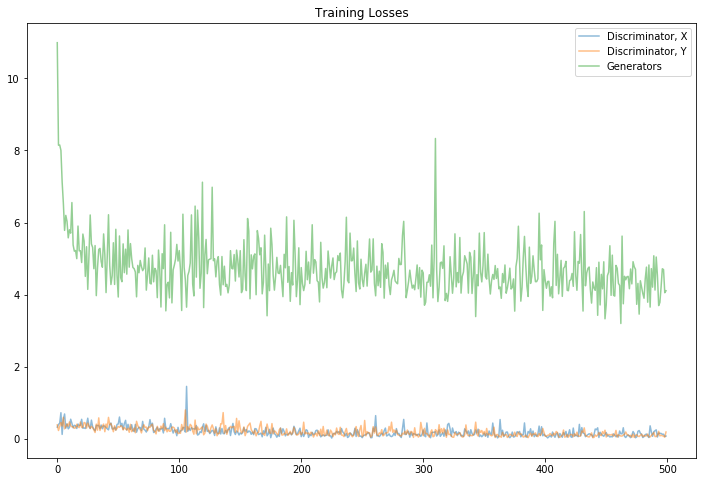

In [0]:
fig, ax = plt.subplots(figsize=(12,8))
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator, X', alpha=0.5)
plt.plot(losses.T[1], label='Discriminator, Y', alpha=0.5)
plt.plot(losses.T[2], label='Generators', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [0]:
import matplotlib.image as mpimg

# helper visualization code
def view_samples(iteration, sample_dir='/content/drive/My Drive/Colab Notebooks/CycleGAN/samples_cyclegan/'):
    
    # samples are named by iteration
    path_XtoY = os.path.join(sample_dir, 'sample-{:06d}-X-Y.png'.format(iteration))
    path_YtoX = os.path.join(sample_dir, 'sample-{:06d}-Y-X.png'.format(iteration))
    
    # read in those samples
    try: 
        x2y = mpimg.imread(path_XtoY)
        y2x = mpimg.imread(path_YtoX)
    except:
        print('Invalid number of iterations.')
    
    fig, (ax1, ax2) = plt.subplots(figsize=(18,20), nrows=2, ncols=1, sharey=True, sharex=True)
    ax1.imshow(x2y)
    ax1.set_title('X to Y')
    ax2.imshow(y2x)
    ax2.set_title('Y to X')


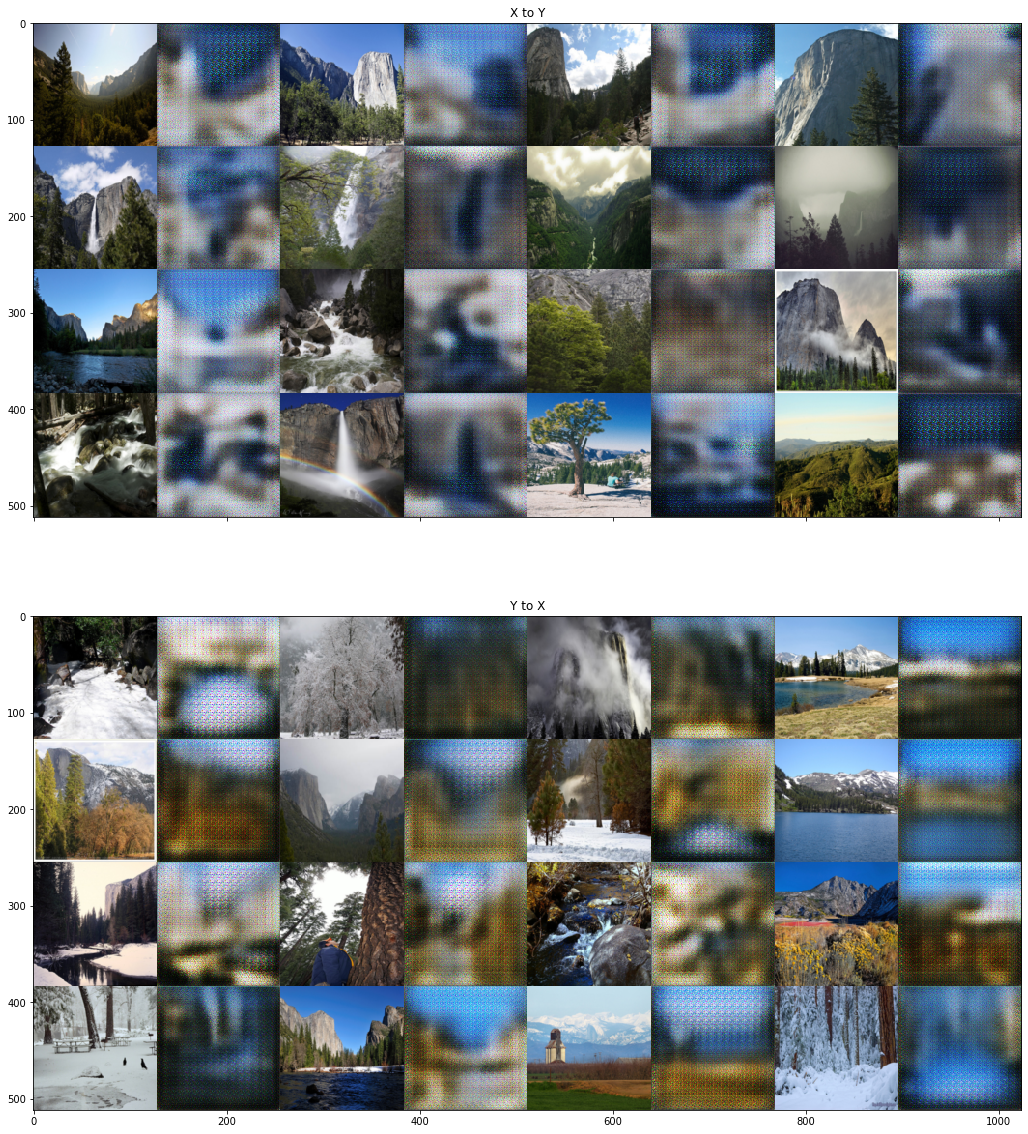

In [0]:
# view samples at iteration 100
view_samples(100, '/content/drive/My Drive/Colab Notebooks/CycleGAN/samples_cyclegan/')

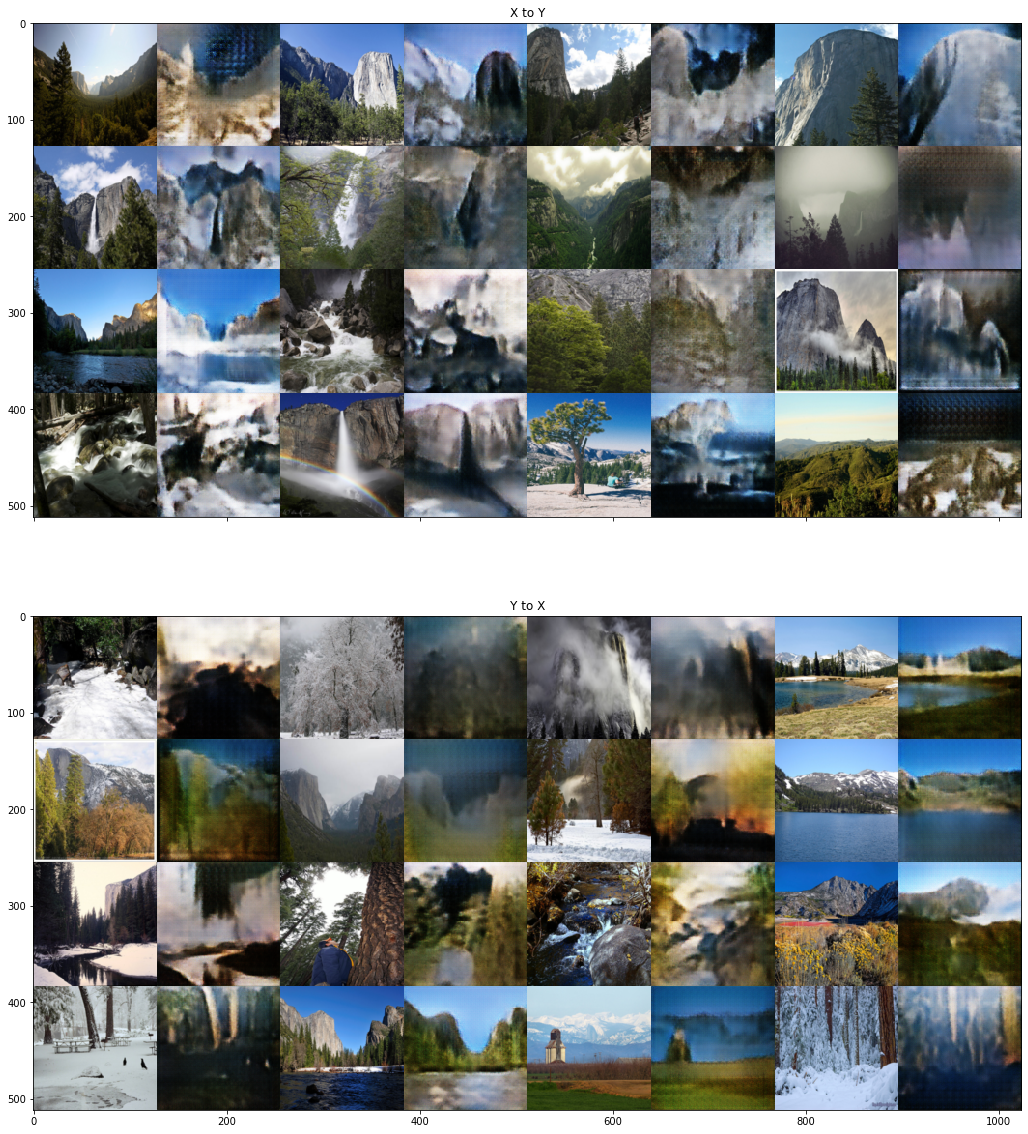

In [0]:
# view samples at iteration 4000
view_samples(4000, '/content/drive/My Drive/Colab Notebooks/CycleGAN/samples_cyclegan/')

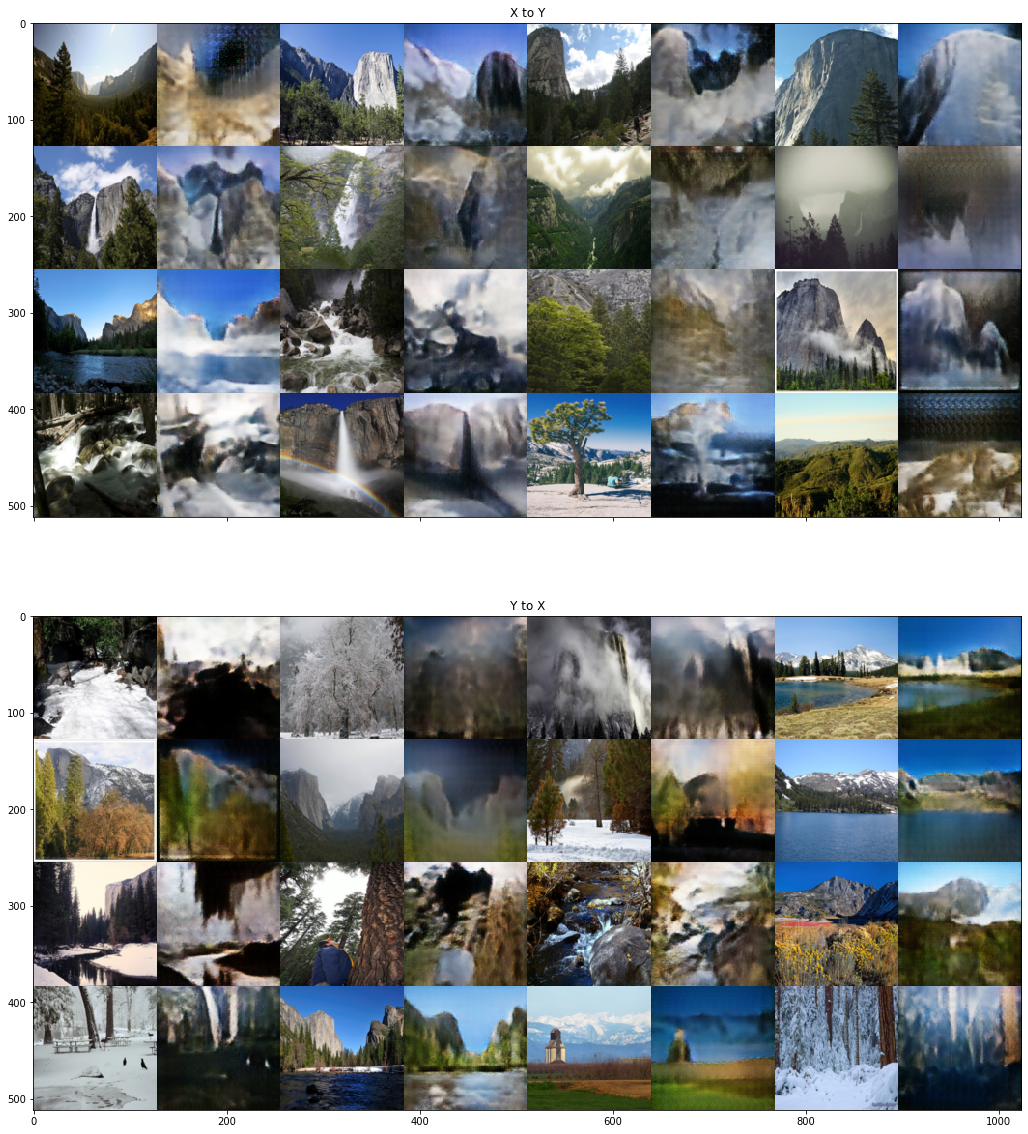

In [0]:
view_samples(5000, '/content/drive/My Drive/Colab Notebooks/CycleGAN/samples_cyclegan/')